In [95]:
import glob
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
%matplotlib inline
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,SimpleRNN

In [2]:
traj = pd.read_csv('dataset_raw_full.csv', low_memory=False)

# Realistic dataset

# Initial Data Exploration, Data preparation and Plotting Trajectory of Filtered Dataset 

In [3]:
traj.tail()

Latitude   Longitude  Altitude            Date_Time  Id_user  \
3387298  40.070186  116.314153     -45.0  2008-11-29 02:01:31      179   
3387299  40.070193  116.314041     -48.0  2008-11-29 02:01:33      179   
3387300  40.070224  116.313923     -51.0  2008-11-29 02:01:35      179   
3387301  40.070227  116.313843     -56.0  2008-11-29 02:01:37      179   
3387302  40.070242  116.313808     -58.0  2008-11-29 02:01:39      179   

                    Id_perc Label  
3387298  20081129015805.plt   bus  
3387299  20081129015805.plt   bus  
3387300  20081129015805.plt   bus  
3387301  20081129015805.plt   bus  
3387302  20081129015805.plt   bus

In [4]:
traj.describe()

Latitude     Longitude      Altitude       Id_user
count  3.387303e+06  3.387303e+06  3.387303e+06  3.387303e+06
mean   3.961094e+01  1.142307e+02  4.284805e+02  9.501306e+01
std    2.397093e+00  1.856440e+01  1.971133e+03  4.728128e+01
min    1.824990e+01 -1.799696e+02 -2.306100e+04  1.000000e+01
25%    3.993521e+01  1.163118e+02  0.000000e+00  6.500000e+01
50%    3.997549e+01  1.163314e+02  1.310000e+02  8.500000e+01
75%    3.999186e+01  1.164181e+02  1.903000e+02  1.280000e+02
max    4.001667e+02  1.799969e+02  4.252950e+04  1.790000e+02

In [5]:
traj['Id_user'].value_counts()

68     449860
128    382820
167    349425
85     261023
10     254722
62     216681
65     192035
126    177681
84     139635
20     138441
153    111019
52      99255
141     98288
115     86069
163     75748
179     66416
112     45774
82      41421
67      37003
78      32987
96      31603
125     25889
64      14357
73      10457
81      10146
75       6673
102      5742
170      3727
69       2988
129      2800
21       1633
138      1596
105      1559
89       1468
56       1205
58       1114
101      1088
139      1023
92        641
161       577
98        557
97        521
144       493
86        389
108       371
91        361
80        355
175       293
111       288
76        232
107       199
117       199
53        196
87         99
136        96
114        57
60          8
Name: Id_user, dtype: int64

In [6]:
tr167 = traj.loc[traj.Id_user==167,:]
tr167['month'] = pd.DatetimeIndex(tr167['Date_Time']).month
tr167 = tr167.loc[tr167.month==4,:]

tr167['date'] = pd.DatetimeIndex(tr167['Date_Time']).date
tr167 = tr167.loc[tr167.month==4,:]
print(tr167['date'].value_counts())

format = '%Y-%m-%d %H:%M:%S'

tr167['Date_Time'] = pd.to_datetime(tr167['Date_Time'], format=format)

tr167 = tr167.reset_index()
tr167 = tr167.drop(['index'], axis=1)
tr167.head()

2008-04-29    3928
2008-04-26    3630
2008-04-27    2356
2008-04-28    1241
2008-04-30    1169
2008-04-25     500
2008-04-04      10
2008-04-05       3
Name: date, dtype: int64


/Users/ponlasitpoopipatpol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Latitude   Longitude    Altitude           Date_Time  Id_user  \
0  39.981150  116.227850  236.220472 2008-04-04 01:52:55      167   
1  39.980967  116.227000  190.288714 2008-04-04 01:54:36      167   
2  39.980667  116.226500  196.850394 2008-04-04 02:06:00      167   
3  39.979833  116.226467  183.727034 2008-04-04 02:07:56      167   
4  39.979700  116.226050  206.692913 2008-04-04 02:16:37      167   

              Id_perc Label  month        date  
0  20080404005918.plt  walk      4  2008-04-04  
1  20080404005918.plt  walk      4  2008-04-04  
2  20080404005918.plt  walk      4  2008-04-04  
3  20080404005918.plt  walk      4  2008-04-04  
4  20080404005918.plt  walk      4  2008-04-04

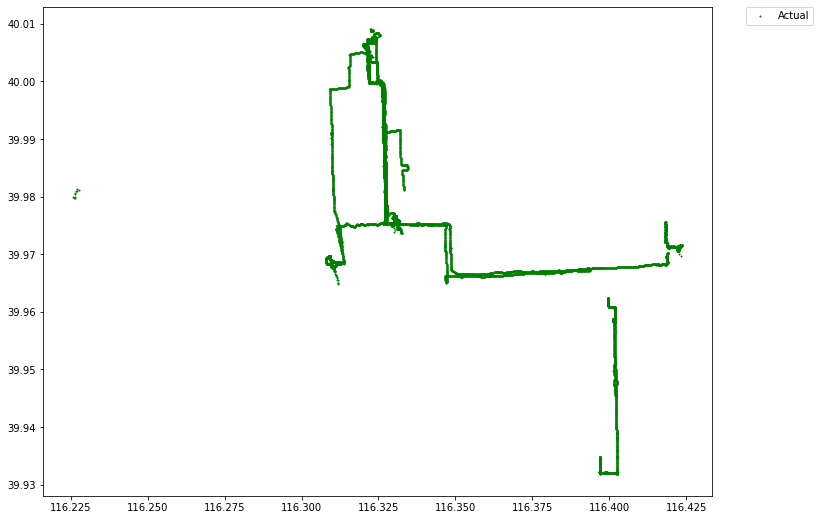

In [7]:
fig = plt.figure(figsize=(12,9))
plt.scatter(tr167['Longitude'],tr167['Latitude'],marker='o',c='g',s=1,alpha=1, label="Actual")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [8]:
# calculate haversine distance and based on that calculate calculated speed
from haversine import haversine, Unit
s1 = tr167.Latitude.min(),tr167.Longitude.min()
s2 = tr167.Latitude.max(),tr167.Longitude.min()
d1 = haversine(s1,s2)*1000
print(d1)

s1 = tr167.Latitude.min(),tr167.Longitude.min()
s2 = tr167.Latitude.min(),tr167.Longitude.max()
d2 = haversine(s1,s2)*1000
print(d2)

8579.590000659398
16857.044197489


In [9]:
df1 = tr167[['Longitude']]
values = df1.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, d2))
df1 = scaler.fit_transform(values)
df1

array([[ 169.],
       [  96.],
       [  54.],
       ...,
       [8041.],
       [8039.],
       [8037.]], dtype=float32)

In [10]:
df2 = tr167[['Latitude']]
values = df2.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, d1))
df2 = scaler.fit_transform(values)
df2

array([[5472.5],
       [5452. ],
       [5418.5],
       ...,
       [8265. ],
       [8264.5],
       [8262.5]], dtype=float32)

In [11]:
df1.max(),df2.max()

(16857.0, 8579.5)

In [598]:
dataset = pd.DataFrame(df1,columns=['X'])
dataset['Y'] = pd.DataFrame(df2)
dataset

X       Y
0       169.0  5472.5
1        96.0  5452.0
2        54.0  5418.5
3        51.0  5325.5
4        16.0  5310.5
...       ...     ...
12832  8043.0  8267.0
12833  8042.0  8266.0
12834  8041.0  8265.0
12835  8039.0  8264.5
12836  8037.0  8262.5

[12837 rows x 2 columns]

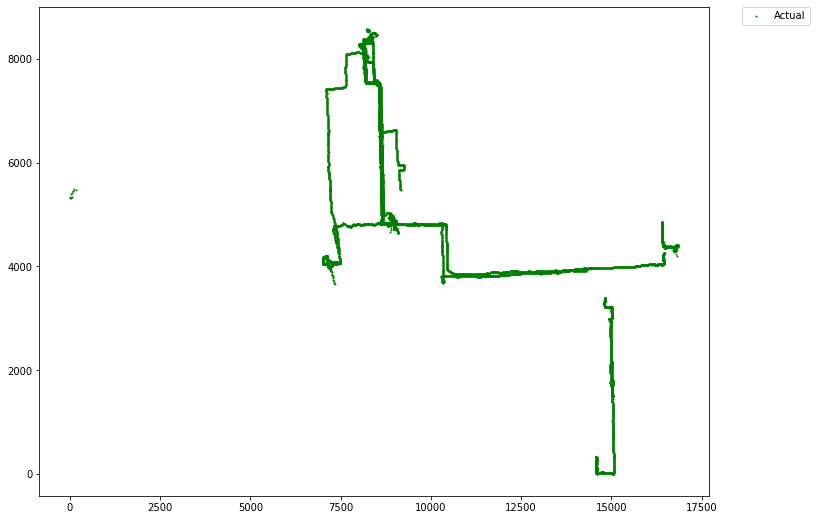

In [13]:
fig = plt.figure(figsize=(12,9))
plt.scatter(dataset['X'],dataset['Y'],marker='o',c='g',s=1,alpha=1, label="Actual")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

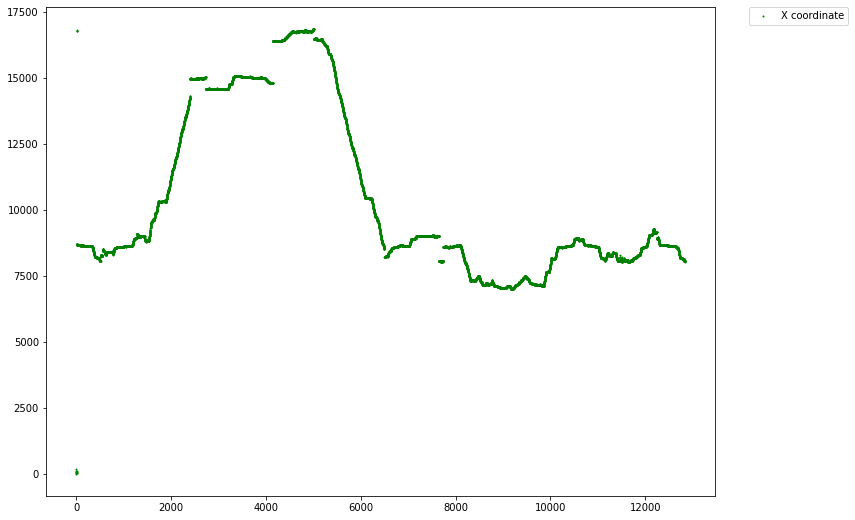

In [75]:
fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(dataset['X'])),dataset['X'],marker='o',c='g',s=1,alpha=1, label="X coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

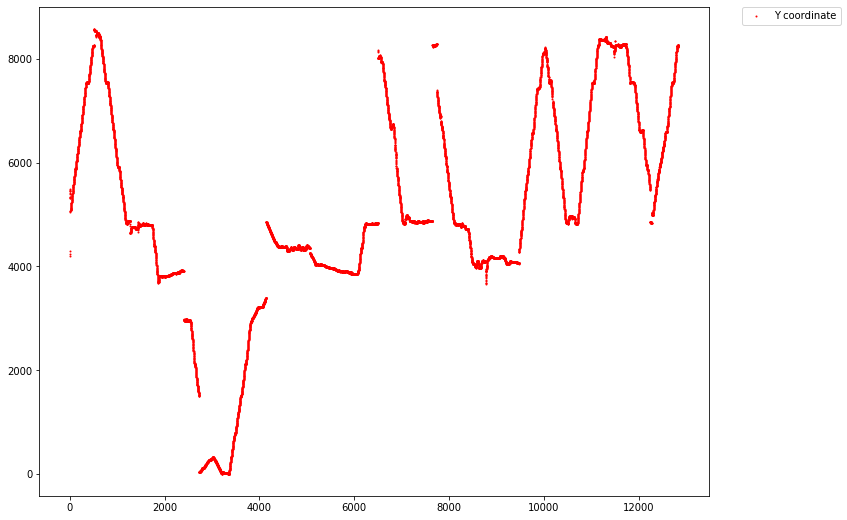

In [76]:
fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(dataset['Y'])),dataset['Y'],marker='o',c='r',s=1,alpha=1, label="Y coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#  Deep learning Models framework for forecasting one step forward of user element.

# Scaling and tranforming trajectory dataset into supervised problem

In [599]:
new_df = dataset

In [600]:
#Multi-input
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = new_df[['X','Y']]
#dataset = pd.DataFrame(new_df)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
print("   Feature Varables       Target Varables")
print(reframed.head())

   Feature Varables       Target Varables
   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1  -0.979949   0.275715 -0.988610  0.270937
2  -0.988610   0.270937 -0.993593  0.263127
3  -0.993593   0.263127 -0.993949  0.241448
4  -0.993949   0.241448 -0.998102  0.237951
5  -0.998102   0.237951 -1.000000  0.245760


# Split data into train and test datasets before feeding the model.

In [601]:
# split into train and test sets
values = reframed.values
n_train = round(reframed.shape[0]*0.2)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, 2:]
test_X, test_y = test[:, :-2], test[:, 2:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2567, 1, 2) (2567, 2) (10269, 1, 2) (10269, 2)


# Train LSTM model

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 64)                17152     
_________________________________________________________________
dropout_86 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 2)                 130       
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 6s - loss: 0.2536 - accuracy: 0.7744 - val_loss: 0.3198 - val_accuracy: 0.9241
Epoch 2/600
36/36 - 0s - loss: 0.2286 - accuracy: 0.9014 - val_loss: 0.2898 - val_accuracy: 0.9810
Epoch 3/600
36/36 - 0s - loss: 0.1937 - accuracy: 0.9178 - val_loss: 0.2610 - val_accuracy: 0.9871
Epoch 4/600
36/36 - 0s - loss: 0.1643 - accuracy: 0.9299 - val_loss: 0.2313 - val_

Epoch 76/600
36/36 - 0s - loss: 0.0194 - accuracy: 0.9922 - val_loss: 0.0326 - val_accuracy: 0.9983
Epoch 77/600
36/36 - 0s - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.0430 - val_accuracy: 0.9965
Epoch 78/600
36/36 - 0s - loss: 0.0225 - accuracy: 0.9883 - val_loss: 0.0365 - val_accuracy: 0.9966
Epoch 79/600
36/36 - 0s - loss: 0.0208 - accuracy: 0.9922 - val_loss: 0.0387 - val_accuracy: 0.9953
Epoch 80/600
36/36 - 0s - loss: 0.0209 - accuracy: 0.9856 - val_loss: 0.0271 - val_accuracy: 0.9992
Epoch 81/600
36/36 - 0s - loss: 0.0195 - accuracy: 0.9899 - val_loss: 0.0329 - val_accuracy: 0.9925
Epoch 82/600
36/36 - 0s - loss: 0.0195 - accuracy: 0.9953 - val_loss: 0.0328 - val_accuracy: 0.9968
Epoch 83/600
36/36 - 0s - loss: 0.0194 - accuracy: 0.9875 - val_loss: 0.0487 - val_accuracy: 0.9413
Epoch 84/600
36/36 - 0s - loss: 0.0243 - accuracy: 0.9840 - val_loss: 0.0270 - val_accuracy: 0.9991
Epoch 85/600
36/36 - 0s - loss: 0.0216 - accuracy: 0.9840 - val_loss: 0.0335 - val_accuracy: 0.9966


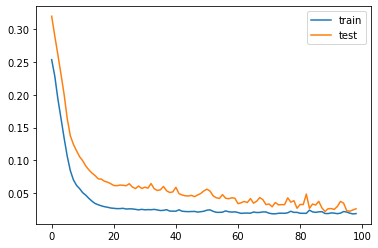

In [602]:
# design single LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model1 = Sequential()
model1.add(LSTM(64,activation='relu' ,input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.1))
model1.add(Dense(test_y.shape[1]))
model1.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model1.summary()
# fit network
history1 = model1.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of LSTM model

In [603]:
yhat = model1.predict(test_X)
_, accuracy = model1.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 988us/step - loss: 0.0222 - accuracy: 0.9990
Accuracy: 99.9026
Test RMSE: 0.040361


# Print error distance by RMSE metric

In [183]:
# make a prediction
yhat = model1.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model1.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmseL = rmse
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)

Test RMSE: 232.770676
Train RMSE: 271.862026


In [184]:
import numpy as np
inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

(array([[ 657.32056, 5379.293  ],
        [ 557.74176, 5365.9062 ],
        [ 490.389  , 5340.7085 ],
        ...,
        [8183.666  , 8254.782  ],
        [8183.0938 , 8253.632  ],
        [8181.8506 , 8253.     ]], dtype=float32),
 array([[  95.99986, 5452.     ],
        [  54.00008, 5418.5    ],
        [  50.99988, 5325.5    ],
        ...,
        [8041.     , 8265.     ],
        [8039.     , 8264.5    ],
        [8037.     , 8262.5    ]], dtype=float32))

# Plot the actual data vs predicted data

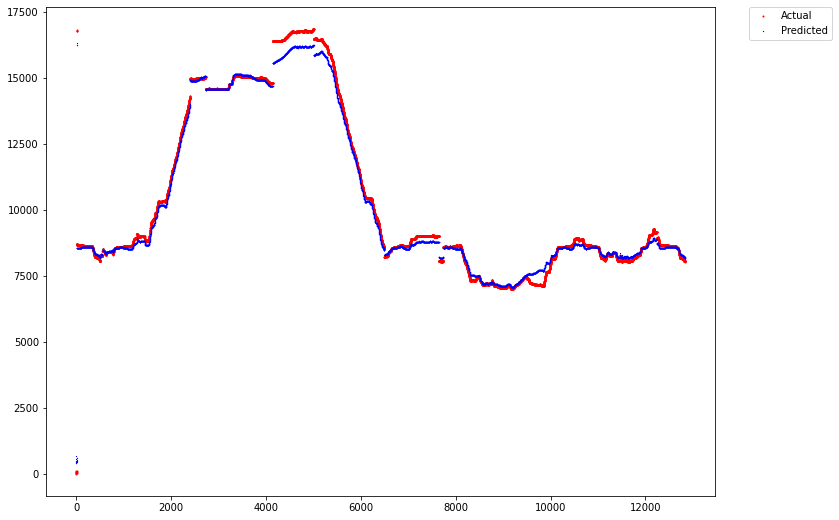

In [185]:
fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

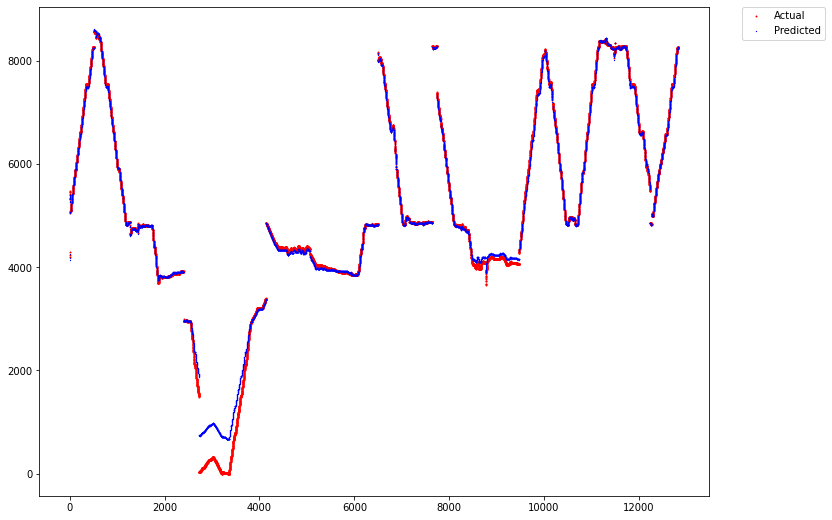

In [186]:
fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [187]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

RMSE for X in Train dataset: 382.042271
RMSE for Y in Train dataset: 43.147408
RMSE for X in Test dataset: 256.222270
RMSE for Y in Test dataset: 206.676151


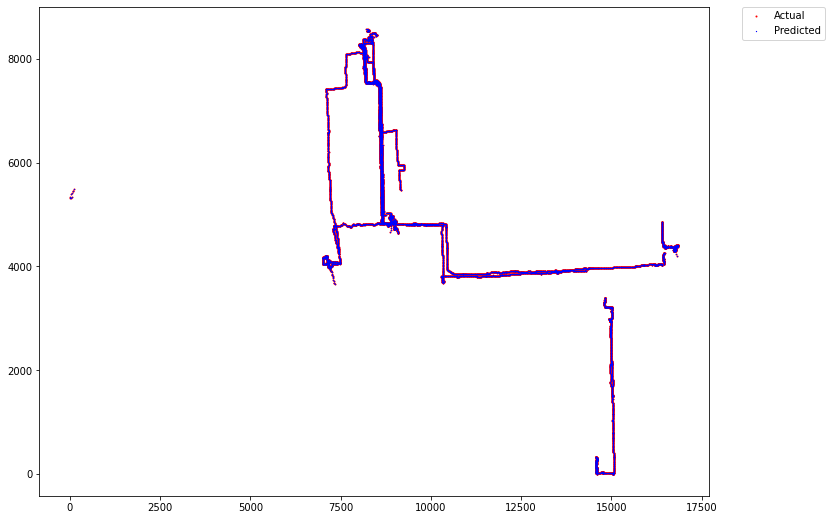

In [188]:

fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train stacked LSTMs

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 64)             17152     
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 258       
Total params: 116,226
Trainable params: 116,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 6s - loss: 0.2536 - accuracy: 0.6034 - val_loss: 0.3163 - val_accuracy: 0.9093
Epoch 2/600
36/36 - 0s - loss: 0.2170 - accuracy: 0.8122 - val_loss: 0.2519 - val_accuracy: 0.9818
Epoch 3/600
36/36 - 0s - loss: 0.1421 - accurac

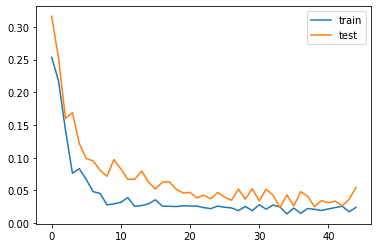

In [104]:
# design stacked LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='auto', patience=10,restore_best_weights=True)

model2 = Sequential()

# first layer
model2.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))

# Second layer
model2.add(LSTM(units=128,return_sequences=False))
model2.add(Dropout(0.1))

# Thrid dense layer
model2.add(Dense(units=(test_y.shape[1])))

model2.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model2.summary()

history2 = model2.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

model2.summary()


# plot history
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of stacked LSTMs model

In [82]:
yhat = model2.predict(test_X)
_, accuracy = model2.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0195 - accuracy: 0.9981
Accuracy: 99.8150
Test RMSE: 0.033195


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 356.818133
Train RMSE: 420.484003
RMSE for X in Train dataset: 573.100695
RMSE for Y in Train dataset: 158.647525
RMSE for X in Test dataset: 459.933980
RMSE for Y in Test dataset: 207.603137


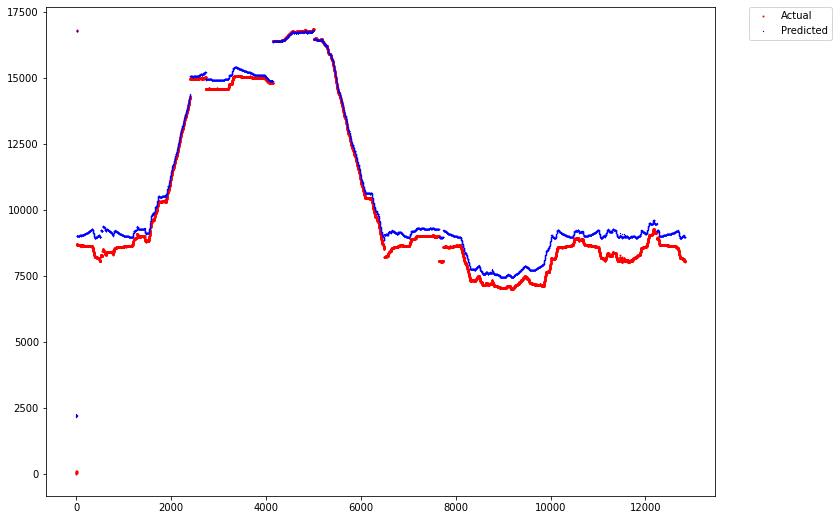

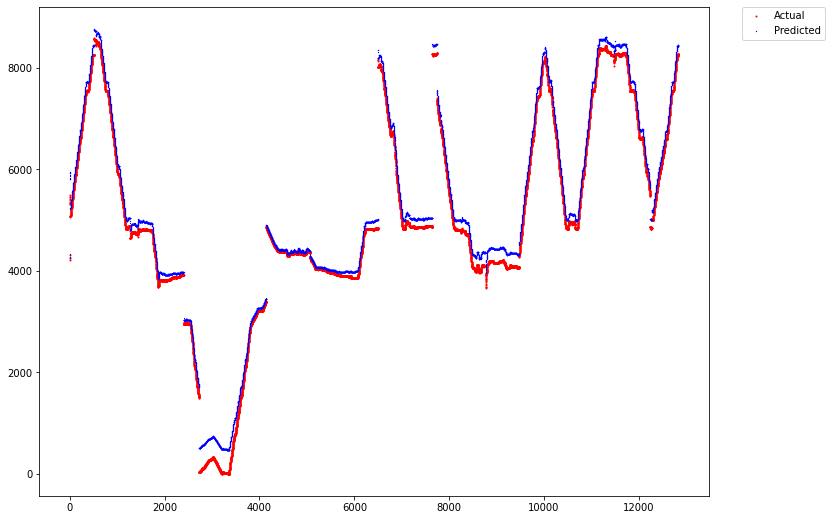

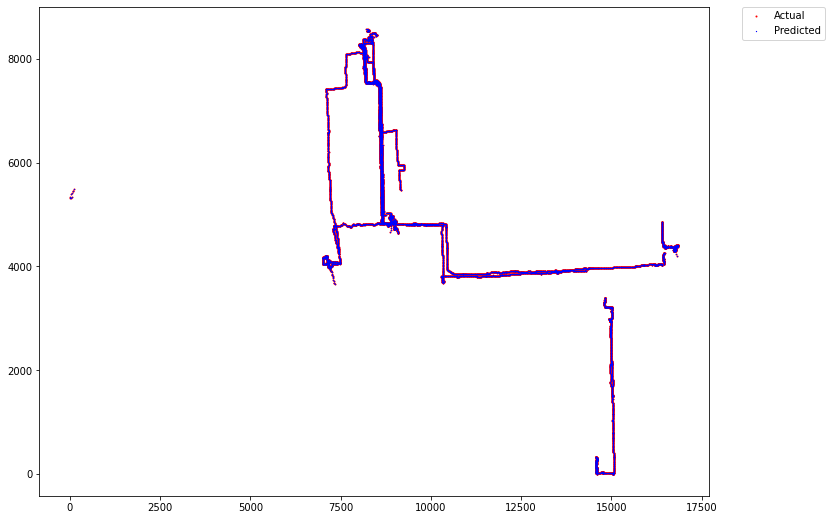

In [110]:
# make a prediction
yhat = model2.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model2.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train Bidirectional LSTM model

Epoch 1/600
36/36 - 8s - loss: 0.2283 - accuracy: 0.8520 - val_loss: 0.2753 - val_accuracy: 0.8868
Epoch 2/600
36/36 - 0s - loss: 0.1749 - accuracy: 0.9264 - val_loss: 0.2023 - val_accuracy: 0.9978
Epoch 3/600
36/36 - 0s - loss: 0.1214 - accuracy: 0.8878 - val_loss: 0.1338 - val_accuracy: 0.9961
Epoch 4/600
36/36 - 0s - loss: 0.0877 - accuracy: 0.9400 - val_loss: 0.0987 - val_accuracy: 0.9919
Epoch 5/600
36/36 - 0s - loss: 0.0705 - accuracy: 0.9907 - val_loss: 0.0782 - val_accuracy: 0.9973
Epoch 6/600
36/36 - 0s - loss: 0.0523 - accuracy: 0.9973 - val_loss: 0.0673 - val_accuracy: 0.9971
Epoch 7/600
36/36 - 0s - loss: 0.0460 - accuracy: 0.9961 - val_loss: 0.0469 - val_accuracy: 0.9984
Epoch 8/600
36/36 - 0s - loss: 0.0288 - accuracy: 0.9895 - val_loss: 0.0503 - val_accuracy: 0.9978
Epoch 9/600
36/36 - 0s - loss: 0.0270 - accuracy: 0.9969 - val_loss: 0.0362 - val_accuracy: 0.9914
Epoch 10/600
36/36 - 0s - loss: 0.0183 - accuracy: 0.9864 - val_loss: 0.0258 - val_accuracy: 0.9969
Epoch 11/

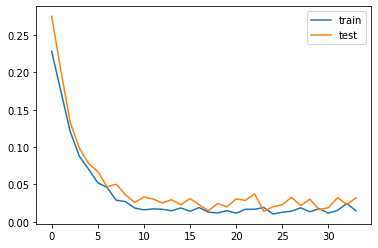

In [429]:
from keras.layers import Bidirectional

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model3 = Sequential()
model3.add(Bidirectional(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2]))))
model3.add(Dropout(0.1))
model3.add(Dense(2))
model3.compile(loss='mae', optimizer='adam',metrics=['accuracy'])


# fit network
history3 = model3.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model3.summary()
# plot history
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of bidirectional LSTM model

In [430]:
yhat = model3.predict(test_X)
_, accuracy = model3.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0139 - accuracy: 0.9990
Accuracy: 99.9026
Test RMSE: 0.022419


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 152.560618
Train RMSE: 256.145985
RMSE for X in Train dataset: 357.831359
RMSE for Y in Train dataset: 56.378553
RMSE for X in Test dataset: 194.569216
RMSE for Y in Test dataset: 93.232546


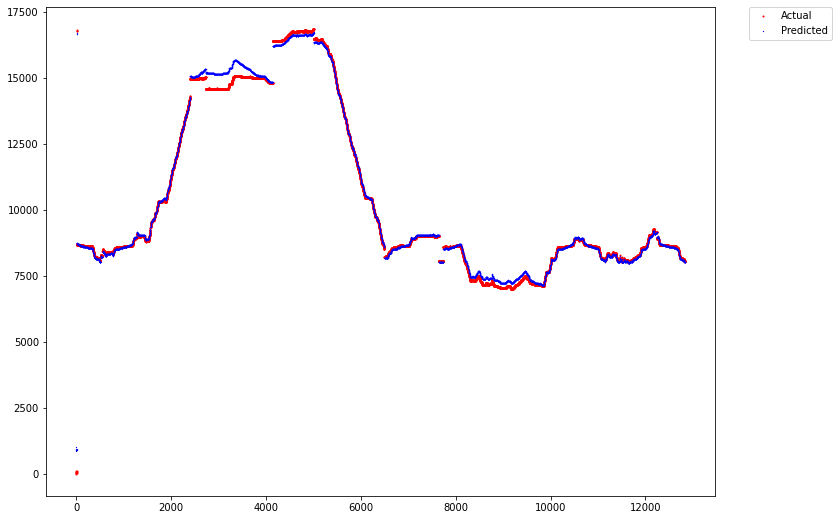

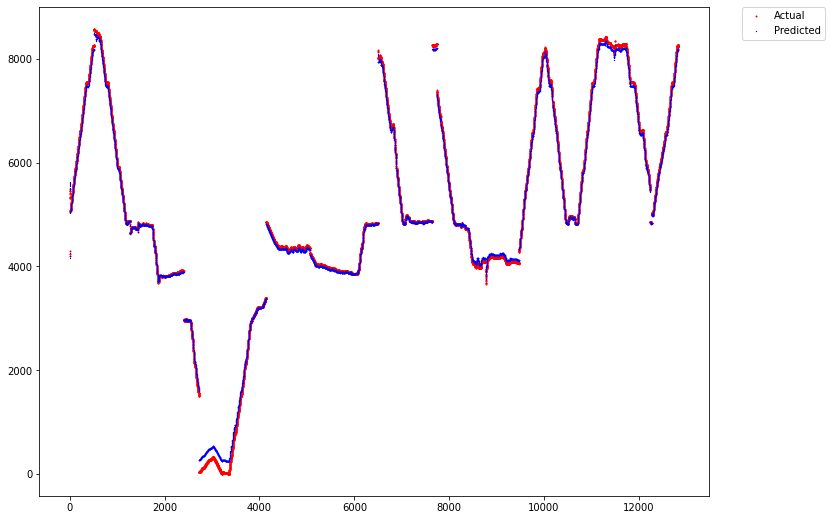

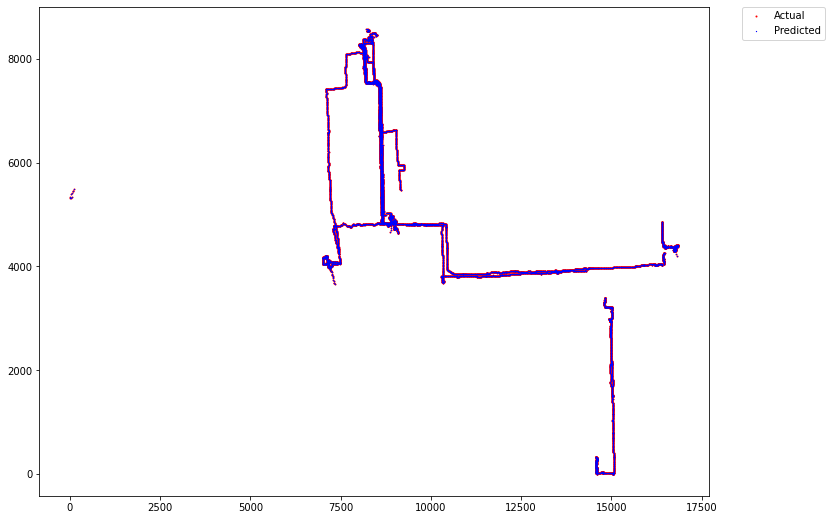

In [431]:
# make a prediction
yhat = model3.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model3.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train GRU model

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 64)                13056     
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 130       
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 4s - loss: 0.2885 - accuracy: 0.3214 - val_loss: 0.3274 - val_accuracy: 0.8306
Epoch 2/600
36/36 - 0s - loss: 0.2182 - accuracy: 0.8344 - val_loss: 0.2643 - val_accuracy: 0.9990
Epoch 3/600
36/36 - 0s - loss: 0.1667 - accuracy: 0.9291 - val_loss: 0.2097 - val_accuracy: 0.9981
Epoch 4/600
36/36 - 0s - loss: 0.1281 - accuracy: 0.9832 - val_loss: 0.1564 - val_

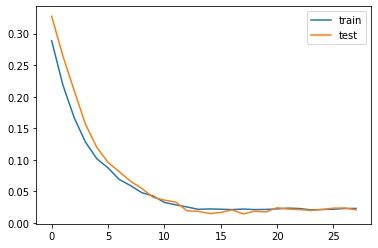

In [432]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model4 = Sequential()
model4.add(GRU(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model4.add(Dropout(0.1))
model4.add(Dense(2))
model4.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model4.summary()
# fit network
history4 = model4.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history4.history['loss'], label='train')
pyplot.plot(history4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of GRU model

In [434]:
yhat = model4.predict(test_X)
_, accuracy = model4.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0145 - accuracy: 0.9983
Accuracy: 99.8345
Test RMSE: 0.026400


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 130.443684
Train RMSE: 265.454798
RMSE for X in Train dataset: 371.172698
RMSE for Y in Train dataset: 56.243431
RMSE for X in Test dataset: 106.344149
RMSE for Y in Test dataset: 150.738767


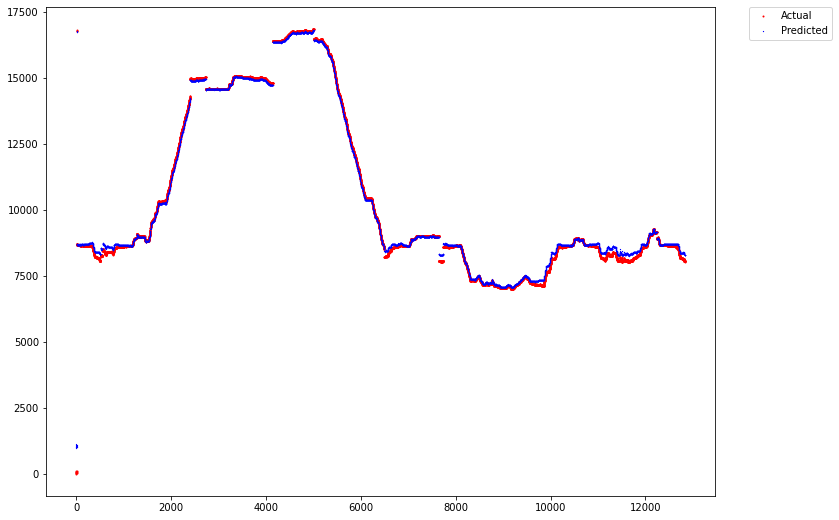

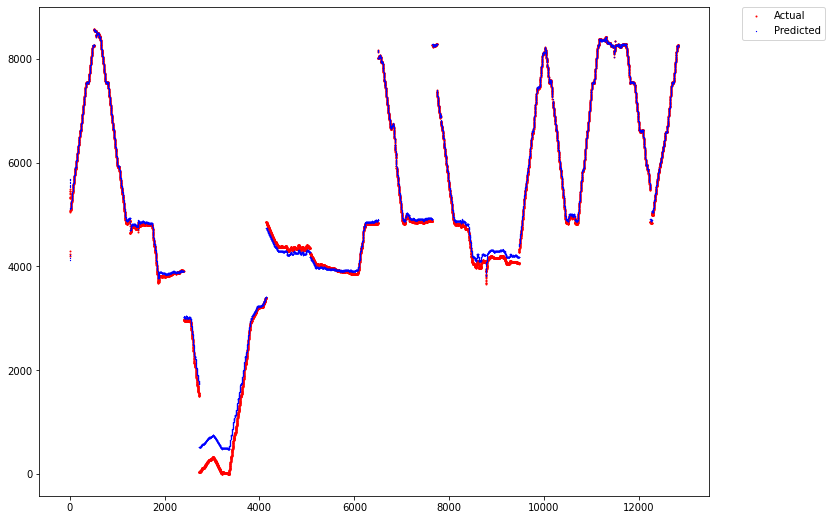

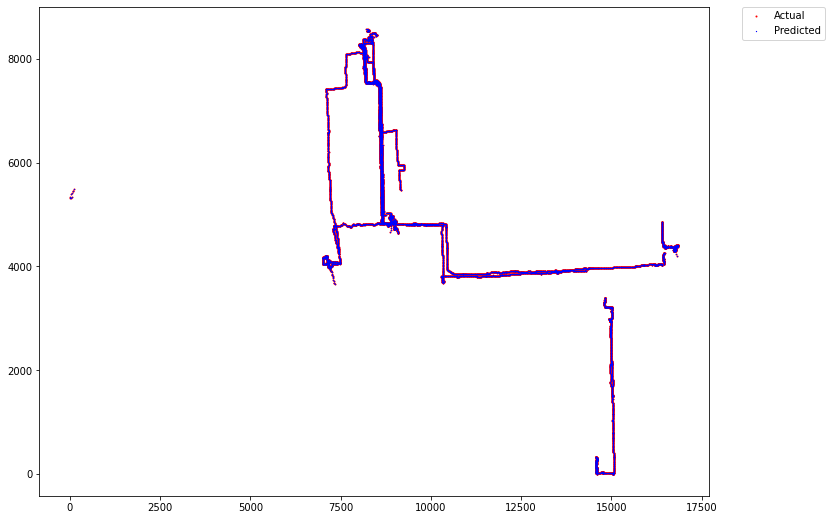

In [435]:
# make a prediction
yhat = model4.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model4.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train stacked GRUs model

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 1, 32)             3456      
_________________________________________________________________
gru_13 (GRU)                 (None, 64)                18816     
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 130       
Total params: 22,402
Trainable params: 22,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 6s - loss: 0.2408 - accuracy: 0.6381 - val_loss: 0.2923 - val_accuracy: 0.8107
Epoch 2/600
36/36 - 0s - loss: 0.1762 - accuracy: 0.9120 - val_loss: 0.2060 - val_accuracy: 0.9595
Epoch 3/600
36/36 - 0s - loss: 0.1226 - accuracy:

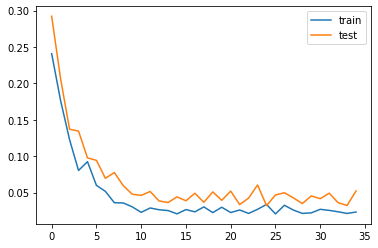

In [438]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model5 = Sequential()
model5.add(GRU(32,return_sequences=True, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))

model5.add(GRU(units=64, activation='tanh',return_sequences=False))
model5.add(Dropout(0.1))
model5.add(Dense(2))
model5.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model5.summary()

# fit network
history5 = model5.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history5.history['loss'], label='train')
pyplot.plot(history5.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of stacked LSTMs model

In [439]:
yhat = model5.predict(test_X)
_, accuracy = model5.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0320 - accuracy: 0.9968
Accuracy: 99.6786
Test RMSE: 0.049239


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 388.537723
Train RMSE: 297.636261
RMSE for X in Train dataset: 413.815101
RMSE for Y in Train dataset: 77.019801
RMSE for X in Test dataset: 535.771173
RMSE for Y in Test dataset: 121.953669


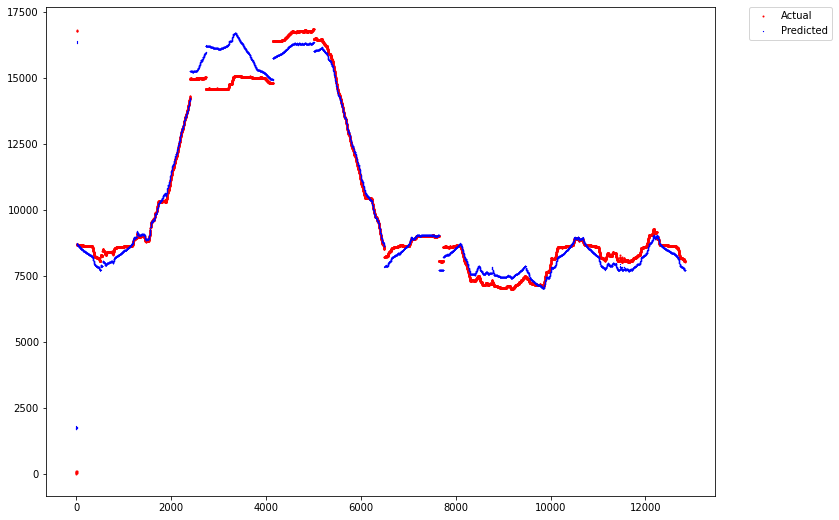

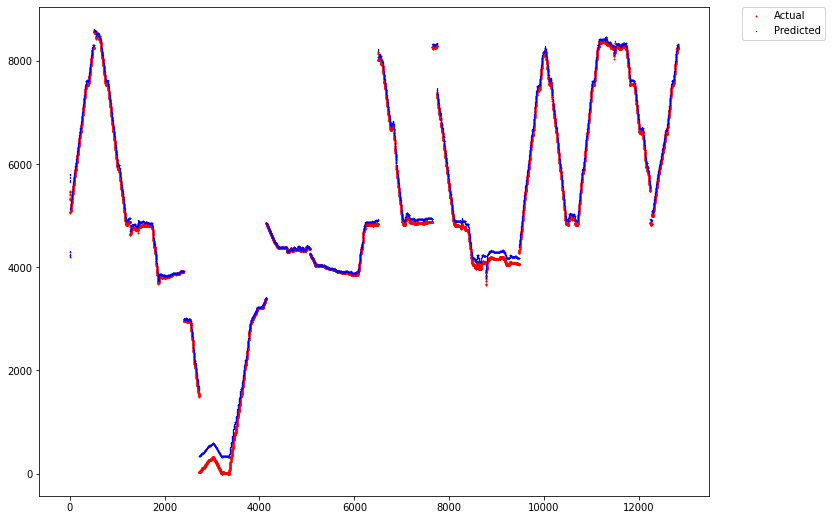

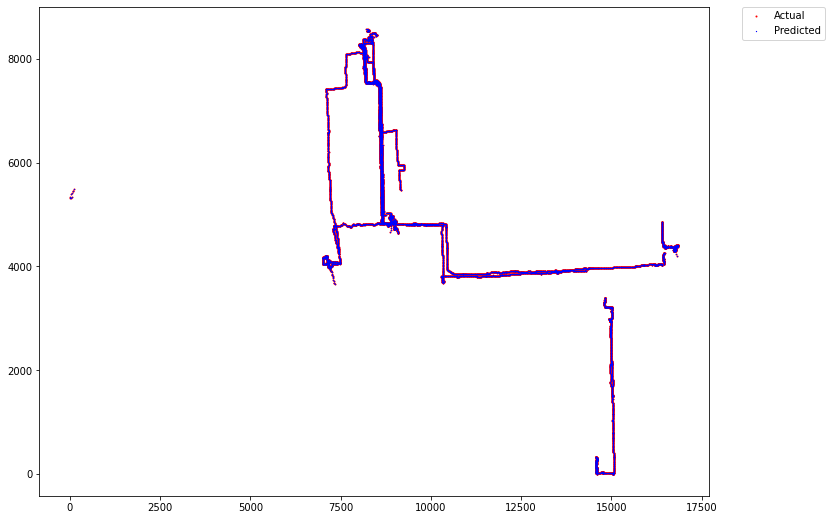

In [440]:
# make a prediction
yhat = model5.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model5.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train stacked RNN model

In [441]:

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model6 = Sequential()
model6.add(SimpleRNN(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model6.add(Dropout(0.1))
model6.add(Dense(2))
model6.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model6.summary()

# fit network
history6 = model6.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history6.history['loss'], label='train')
pyplot.plot(history6.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 64)                4288      
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 130       
Total params: 4,418
Trainable params: 4,418
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 3s - loss: 0.2801 - accuracy: 0.4254 - val_loss: 0.3000 - val_accuracy: 0.5253
Epoch 2/600
36/36 - 0s - loss: 0.1756 - accuracy: 0.7589 - val_loss: 0.2045 - val_accuracy: 0.9981
Epoch 3/600
36/36 - 0s - loss: 0.1558 - accuracy: 0.8816 - val_loss: 0.1318 - val_accuracy: 0.9976
Epoch 4/600
36/36 - 0s - loss: 0.0997 - accuracy: 0.9536 - val_loss: 0.0971 - val_ac

# Display accuracy of RNN model

In [442]:
yhat = model6.predict(test_X)
_, accuracy = model6.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 937us/step - loss: 0.0097 - accuracy: 0.9986
Accuracy: 99.8637
Test RMSE: 0.015427


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 96.274033
Train RMSE: 268.273662
RMSE for X in Train dataset: 376.556644
RMSE for Y in Train dataset: 46.332428
RMSE for X in Test dataset: 114.878689
RMSE for Y in Test dataset: 73.076877


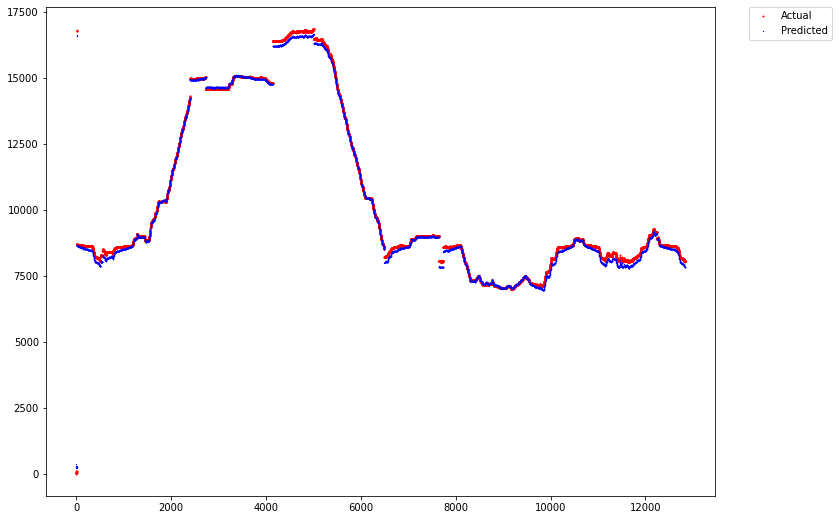

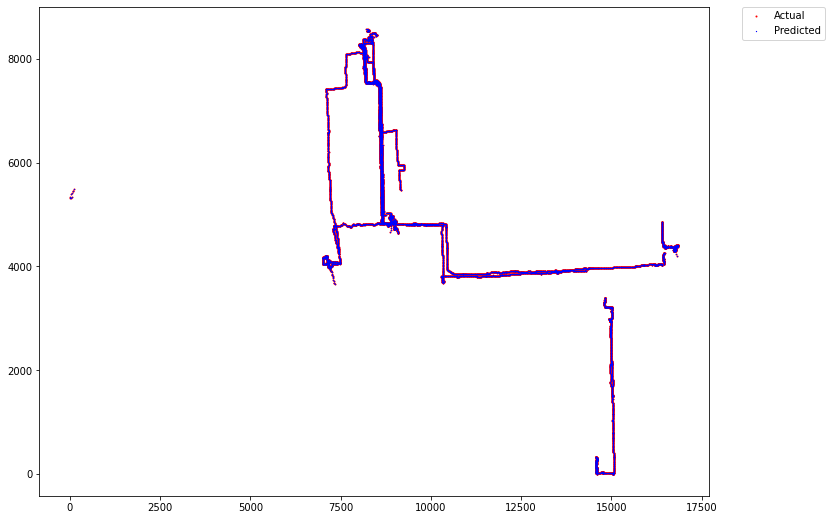

In [443]:
# make a prediction
yhat = model6.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model6.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Deep learning Models framework for forecasting multi steps of the user element

# Break down X and Y coordinates, scale and transfrom them to correspond the multi steps feature

In [513]:
new_df = dataset

# Transforming X coordinate data into supervised problem

In [514]:
#Single-input Multi-steps
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = new_df[['X']]
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler1.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 5, 3)

print("                           X coordinate dataset")
print(reframed.head())


                           X coordinate dataset
   var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)  var1(t+1)  \
5  -0.979949  -0.988610  -0.993593  -0.993949  -0.998102 -1.000000  -0.995492   
6  -0.988610  -0.993593  -0.993949  -0.998102  -1.000000 -0.995492  -0.995492   
7  -0.993593  -0.993949  -0.998102  -1.000000  -0.995492 -0.995492  -0.990864   
8  -0.993949  -0.998102  -1.000000  -0.995492  -0.995492 -0.990864  -0.987186   
9  -0.998102  -1.000000  -0.995492  -0.995492  -0.990864 -0.987186   0.991339   

   var1(t+2)  
5  -0.995492  
6  -0.990864  
7  -0.987186  
8   0.991339  
9   0.991220  


# Split data into train and test datasets before feeding the model for X coordinate

In [515]:
# split into train and test sets
values = reframed.values
n_train = round(values.shape[0]*0.2)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y_1 = train[:, :-3], train[:, 5:]
test_X, test_y_1 = test[:, :-3], test[:, 5:]
# reshape input to be 3D [samples, timesteps, features]
train_X_1 = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_1 = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X_1.shape, train_y_1.shape, test_X_1.shape, test_y_1.shape)

(2566, 1, 5) (2566, 3) (10264, 1, 5) (10264, 3)


# Transforming Y coordinate data into supervised problem

In [516]:
#Single-input Multi-steps
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = new_df[['Y']]
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler2 = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler2.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 5, 3)
print("                           Y coordinate dataset")
print(reframed.head())


                           Y coordinate dataset
   var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)  var1(t+1)  \
5   0.275715   0.270937   0.263127   0.241448   0.237951  0.245760   0.240632   
6   0.270937   0.263127   0.241448   0.237951   0.245760  0.240632   0.257416   
7   0.263127   0.241448   0.237951   0.245760   0.240632  0.257416   0.270004   
8   0.241448   0.237951   0.245760   0.240632   0.257416  0.270004   0.277697   
9   0.237951   0.245760   0.240632   0.257416   0.270004  0.277697   0.002506   

   var1(t+2)  
5   0.257416  
6   0.270004  
7   0.277697  
8   0.002506  
9  -0.011248  


# Split data into train and test datasets before feeding the model for Y coordinate

In [517]:
# split into train and test sets
values = reframed.values
n_train = round(values.shape[0]*0.2)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y_2 = train[:, :-3], train[:, 5:]
test_X, test_y_2 = test[:, :-3], test[:, 5:]
# reshape input to be 3D [samples, timesteps, features]
train_X_2 = train_X_2.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_2 = test_X_2.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X_2.shape, train_y_2.shape, test_X_2.shape, test_y_2.shape)

(2566, 1, 5) (2566, 3) (10264, 1, 5) (10264, 3)


In [518]:
train_X_1.shape[1], train_X_1.shape[2],test_y_1.shape[1]

(1, 5, 3)

# Train LSTM model for X coordinate

In [561]:
# design single LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modelx = Sequential()
modelx.add(LSTM(64,activation='relu' ,input_shape=(train_X_1.shape[1], train_X_1.shape[2])))
modelx.add(Dropout(0.1))
modelx.add(Dense(test_y_1.shape[1]))
modelx.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
# fit network
historyx = modelx.fit(train_X_1, train_y_1, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_1, test_y_1), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyx.history['loss'], label='train')
pyplot.plot(historyx.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/600
36/36 - 4s - loss: 0.1455 - accuracy: 0.4353 - val_loss: 0.2387 - val_accuracy: 0.3401
Epoch 2/600
36/36 - 0s - loss: 0.1150 - accuracy: 0.4454 - val_loss: 0.1831 - val_accuracy: 0.3481
Epoch 3/600
36/36 - 0s - loss: 0.0746 - accuracy: 0.4669 - val_loss: 0.0997 - val_accuracy: 0.3374
Epoch 4/600
36/36 - 0s - loss: 0.0434 - accuracy: 0.4751 - val_loss: 0.0562 - val_accuracy: 0.4038
Epoch 5/600
36/36 - 0s - loss: 0.0292 - accuracy: 0.4353 - val_loss: 0.0284 - val_accuracy: 0.2385
Epoch 6/600
36/36 - 0s - loss: 0.0218 - accuracy: 0.3196 - val_loss: 0.0249 - val_accuracy: 0.1559
Epoch 7/600
36/36 - 0s - loss: 0.0204 - accuracy: 0.2931 - val_loss: 0.0316 - val_accuracy: 0.3610
Epoch 8/600
36/36 - 0s - loss: 0.0208 - accuracy: 0.4423 - val_loss: 0.0215 - val_accuracy: 0.3870
Epoch 9/600
36/36 - 0s - loss: 0.0188 - accuracy: 0.3449 - val_loss: 0.0242 - val_accuracy: 0.1989
Epoch 10/600
36/36 - 0s - loss: 0.0184 - accuracy: 0.3441 - val_loss: 0.0233 - val_accuracy: 0.2553
Epoch 11/

# Train LSTM model for Y coordinate

Epoch 1/600
36/36 - 4s - loss: 0.3245 - accuracy: 0.4587 - val_loss: 0.3090 - val_accuracy: 0.4750
Epoch 2/600
36/36 - 0s - loss: 0.2448 - accuracy: 0.4657 - val_loss: 0.2306 - val_accuracy: 0.4403
Epoch 3/600
36/36 - 0s - loss: 0.1598 - accuracy: 0.4579 - val_loss: 0.1333 - val_accuracy: 0.4429
Epoch 4/600
36/36 - 0s - loss: 0.0669 - accuracy: 0.4150 - val_loss: 0.0841 - val_accuracy: 0.1726
Epoch 5/600
36/36 - 0s - loss: 0.0382 - accuracy: 0.3141 - val_loss: 0.0581 - val_accuracy: 0.4072
Epoch 6/600
36/36 - 0s - loss: 0.0372 - accuracy: 0.3504 - val_loss: 0.0492 - val_accuracy: 0.3776
Epoch 7/600
36/36 - 0s - loss: 0.0362 - accuracy: 0.3258 - val_loss: 0.0539 - val_accuracy: 0.3594
Epoch 8/600
36/36 - 0s - loss: 0.0361 - accuracy: 0.4018 - val_loss: 0.0393 - val_accuracy: 0.4034
Epoch 9/600
36/36 - 0s - loss: 0.0328 - accuracy: 0.3211 - val_loss: 0.0415 - val_accuracy: 0.4058
Epoch 10/600
36/36 - 0s - loss: 0.0326 - accuracy: 0.3328 - val_loss: 0.0411 - val_accuracy: 0.1923
Epoch 11/

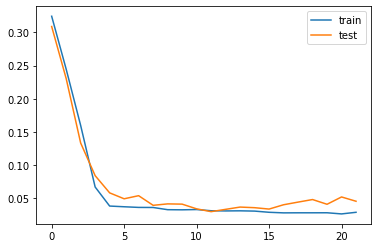

In [562]:
# design single LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modely = Sequential()
modely.add(LSTM(64,activation='relu' ,input_shape=(train_X_2.shape[1], train_X_2.shape[2])))
modely.add(Dropout(0.1))
modely.add(Dense(test_y_2.shape[1]))
modely.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
# fit network
historyy = modely.fit(train_X_2, train_y_2, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_2, test_y_2), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyy.history['loss'], label='train')
pyplot.plot(historyy.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of LSTM model for both X and Y models

In [565]:
yhat = modelx.predict(test_X_1)
_, accuracy = modelx.evaluate(test_X_1, test_y_1)
print('Accuracy of X model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_1, yhat))
print('Test RMSE: %.6f' % rmse)

yhat = modelx.predict(test_X_2)
_, accuracy = modelx.evaluate(test_X_2, test_y_2)
print('Accuracy of Y model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_2, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 988us/step - loss: 0.0215 - accuracy: 0.3870
Accuracy of X model: 38.6984
Test RMSE: 0.036682
321/321 [==============================] - 0s 993us/step - loss: 0.0804 - accuracy: 0.3654
Accuracy of Y model: 36.5355
Test RMSE: 0.193980


# Print error distance by RMSE metric and Plot the actual data vs predicted data for 1,2 and 3 step forwards

Test RMSE: 309.173204
Test RMSE: 190.177241
Train RMSE: 439.973437
Train RMSE: 139.703460
RMSE: 268.093559
1 step forward
RMSE for X in Train dataset: 433.489709
RMSE for Y in Train dataset: 149.844535
RMSE for X in Test dataset: 274.634587
RMSE for Y in Test dataset: 227.309398


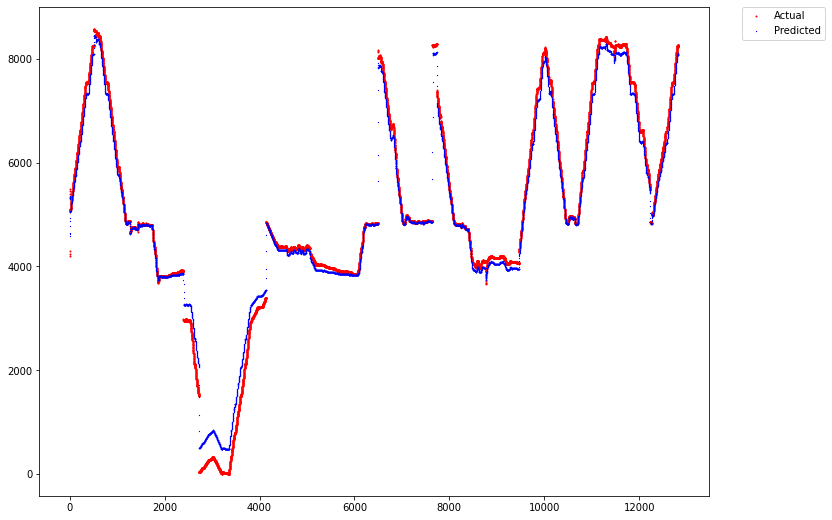

2 step forward
RMSE: 265.154097
RMSE for X in Train dataset: 448.409045
RMSE for Y in Train dataset: 136.726582
RMSE for X in Test dataset: 309.215274
RMSE for Y in Test dataset: 158.781124


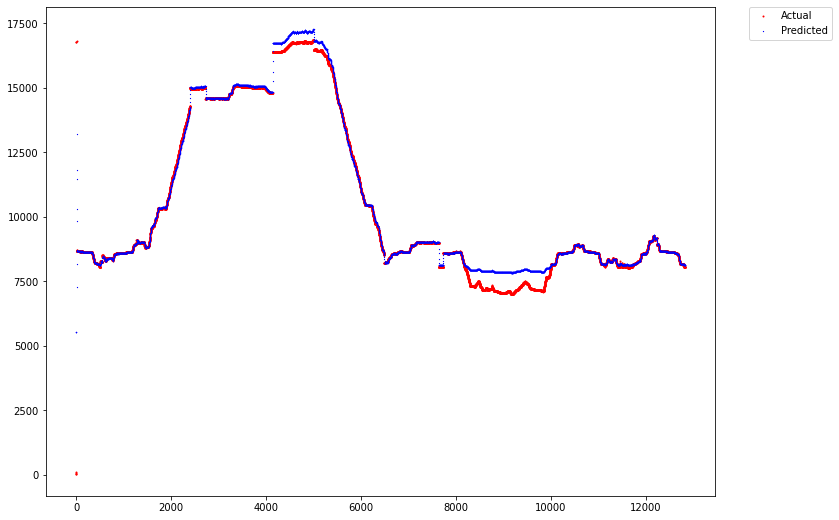

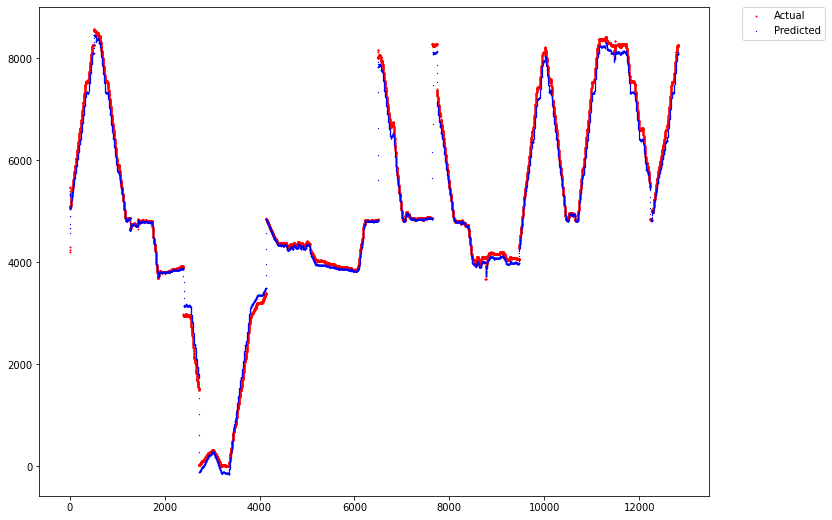

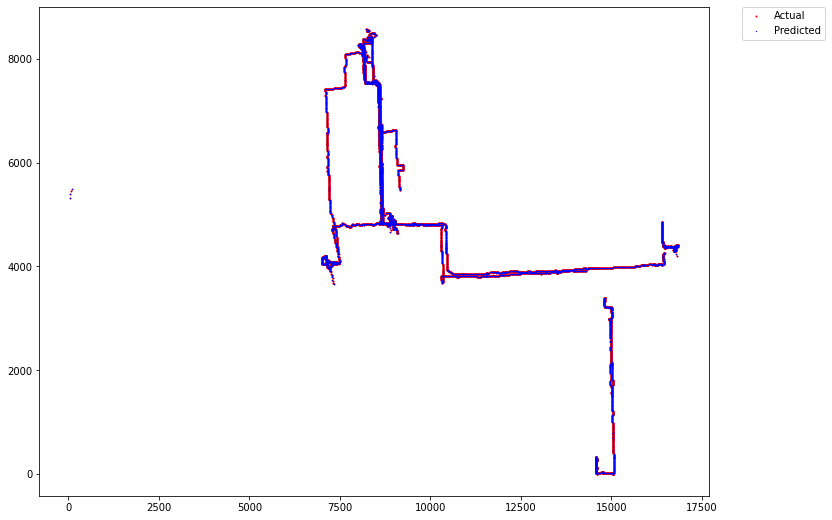

3 step forward
RMSE: 282.585814
RMSE for X in Train dataset: 437.890130
RMSE for Y in Train dataset: 131.923036
RMSE for X in Test dataset: 340.188057
RMSE for Y in Test dataset: 177.823160


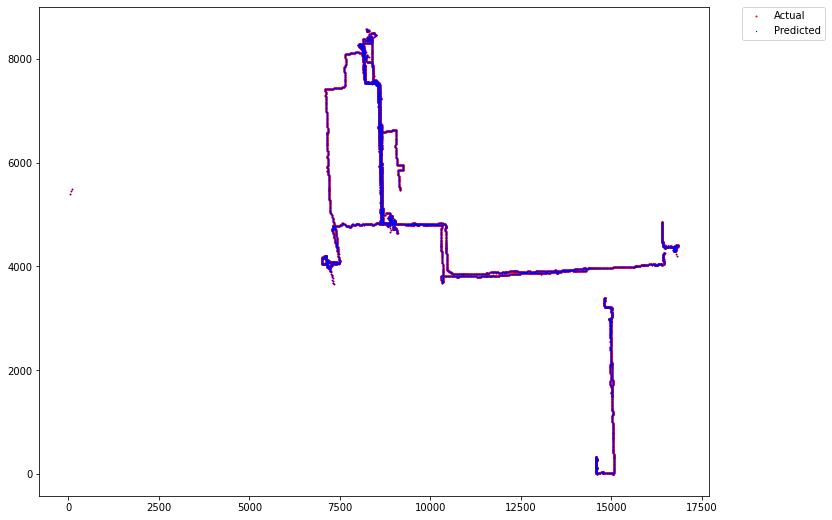

In [564]:
# make a prediction
yhatx = modelx.predict(test_X_1)

# invert scaling for forecast
inv_yhatx = scaler1.inverse_transform(yhatx)
# invert scaling for actual
inv_yx = scaler1.inverse_transform(test_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx, inv_yhatx))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhaty = modely.predict(test_X_2)

# invert scaling for forecast
inv_yhaty = scaler2.inverse_transform(yhaty)
# invert scaling for actual
inv_yy = scaler2.inverse_transform(test_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy, inv_yhaty))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhatx2 = modelx.predict(train_X_1)

# invert scaling for forecast
inv_yhatx2 = scaler1.inverse_transform(yhatx2)
# invert scaling for actual
inv_yx2 = scaler1.inverse_transform(train_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx2, inv_yhatx2))
print('Train RMSE: %.6f' % rmse)

# make a prediction
yhaty2 = modely.predict(train_X_2)

# invert scaling for forecast
inv_yhaty2 = scaler2.inverse_transform(yhaty2)
# invert scaling for actual
inv_yy2 = scaler2.inverse_transform(train_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy2, inv_yhaty2))
print('Train RMSE: %.6f' % rmse)

# 1 step forward

df_marks2 = pd.DataFrame(inv_yhatx2[:,0],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,0])

df_marks = pd.DataFrame(inv_yhatx[:,0],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,0])


df_marks3 = pd.DataFrame(inv_yx2[:,0],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,0])

df_marks4 = pd.DataFrame(inv_yx[:,0],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,0])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


print("1 step forward")
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 2 step forward
print("2 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,1],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,1])

df_marks = pd.DataFrame(inv_yhatx[:,1],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,1])


df_marks3 = pd.DataFrame(inv_yx2[:,1],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,1])

df_marks4 = pd.DataFrame(inv_yx[:,1],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,1])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)



# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 3 step forward
print("3 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,2],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,2])

df_marks = pd.DataFrame(inv_yhatx[:,2],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,2])


df_marks3 = pd.DataFrame(inv_yx2[:,2],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,2])

df_marks4 = pd.DataFrame(inv_yx[:,2],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,2])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train stacked LSTMs models for each X coordinate and Y coordinate

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 1, 64)             17920     
_________________________________________________________________
lstm_58 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_70 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 3)                 387       
Total params: 117,123
Trainable params: 117,123
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 6s - loss: 0.1341 - accuracy: 0.1224 - val_loss: 0.2198 - val_accuracy: 0.1213
Epoch 2/600
36/36 - 0s - loss: 0.0911 - accuracy: 0.1118 - val_loss: 0.0567 - val_accuracy: 0.1798
Epoch 3/600
36/36 - 0s - loss: 0.0454 - accurac

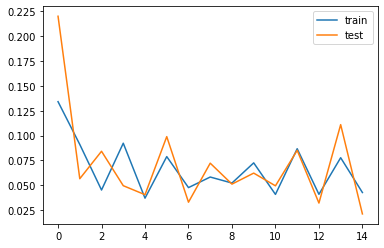

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 1, 64)             17920     
_________________________________________________________________
lstm_60 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_71 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 3)                 387       
Total params: 117,123
Trainable params: 117,123
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 6s - loss: 0.3302 - accuracy: 0.5008 - val_loss: 0.2555 - val_accuracy: 0.3494
Epoch 2/600
36/36 - 0s - loss: 0.1620 - accuracy: 0.3359 - val_loss: 0.1123 - val_accuracy: 0.0761
Epoch 3/600
36/36 - 0s - loss: 0.0274 - accurac

In [567]:
# design stacked LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='auto', patience=10,restore_best_weights=True)

modelx = Sequential()

# first layer
modelx.add(LSTM(64, input_shape=(train_X_1.shape[1], train_X_1.shape[2]),return_sequences=True))

# Second layer
modelx.add(LSTM(units=128,return_sequences=False))
modelx.add(Dropout(0.1))

# Thrid dense layer
modelx.add(Dense(units=(test_y_1.shape[1])))

modelx.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modelx.summary()

historyx = modelx.fit(train_X_1, train_y_1, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_1, test_y_1), verbose=2, shuffle=False)

modelx.summary()

# plot history
pyplot.plot(historyx.history['loss'], label='train')
pyplot.plot(historyx.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



# design stacked LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='auto', patience=10,restore_best_weights=True)

modely = Sequential()

# first layer
modely.add(LSTM(64, input_shape=(train_X_2.shape[1], train_X_2.shape[2]),return_sequences=True))

# Second layer
modely.add(LSTM(units=128,return_sequences=False))
modely.add(Dropout(0.1))

# Thrid dense layer
modely.add(Dense(units=(test_y_2.shape[1])))

modely.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modely.summary()

historyy = modely.fit(train_X_2, train_y_2, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_2, test_y_2), verbose=2, shuffle=False)

modely.summary()

# plot history
pyplot.plot(historyy.history['loss'], label='train')
pyplot.plot(historyy.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()






# Display accuracy of stacked LSTMs model for both X and Y models

In [568]:
yhat = modelx.predict(test_X_1)
_, accuracy = modelx.evaluate(test_X_1, test_y_1)
print('Accuracy of X model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_1, yhat))
print('Test RMSE: %.6f' % rmse)

yhat = modelx.predict(test_X_2)
_, accuracy = modelx.evaluate(test_X_2, test_y_2)
print('Accuracy of Y model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_2, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0407 - accuracy: 0.2670
Accuracy of X model: 26.7050
Test RMSE: 0.047277
321/321 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.1948
Accuracy of Y model: 19.4758
Test RMSE: 0.165874


# Print error distance by RMSE metric and Plot the actual data vs predicted data for 1,2 and 3 step forwards

Test RMSE: 398.477493
Test RMSE: 177.931166
Train RMSE: 673.020872
Train RMSE: 103.208640
RMSE: 353.343594
1 step forward
RMSE for X in Train dataset: 712.850900
RMSE for Y in Train dataset: 106.571284
RMSE for X in Test dataset: 391.678400
RMSE for Y in Test dataset: 169.819913


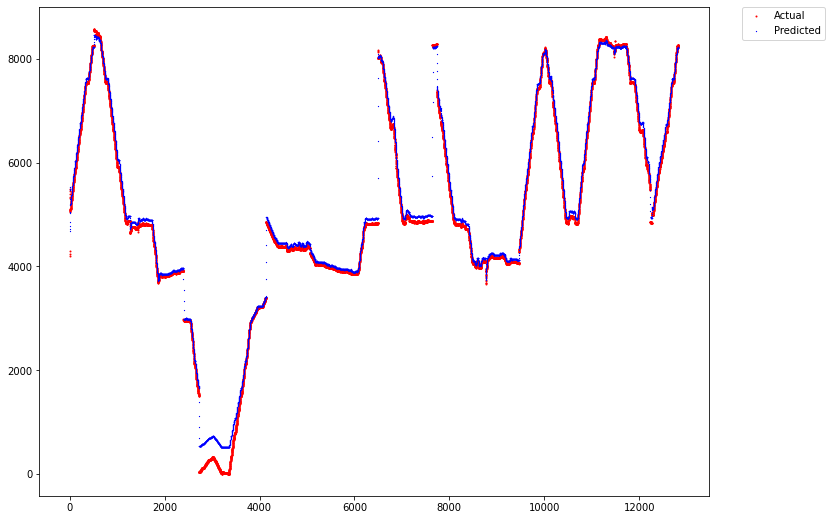

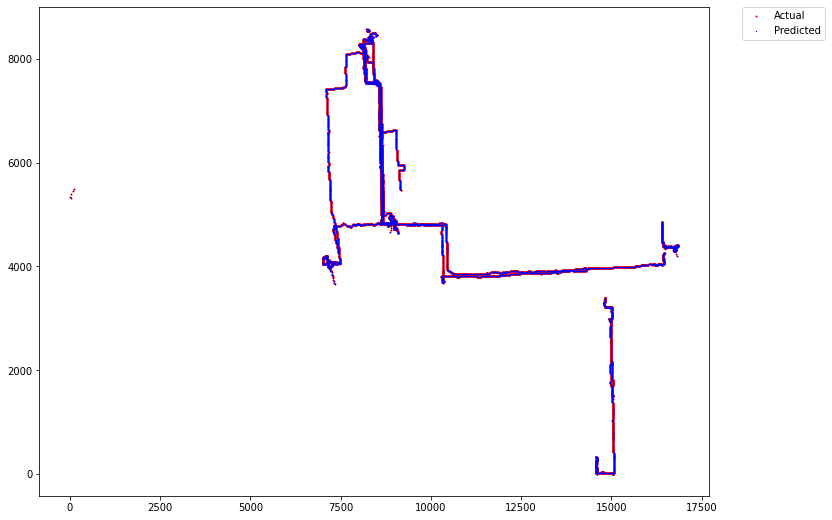

2 step forward
RMSE: 335.533321
RMSE for X in Train dataset: 601.136788
RMSE for Y in Train dataset: 96.639457
RMSE for X in Test dataset: 395.275280
RMSE for Y in Test dataset: 180.382488


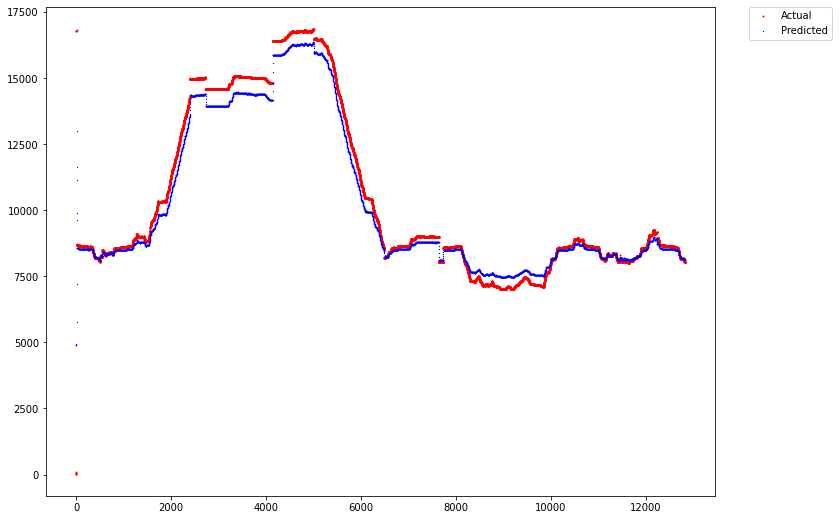

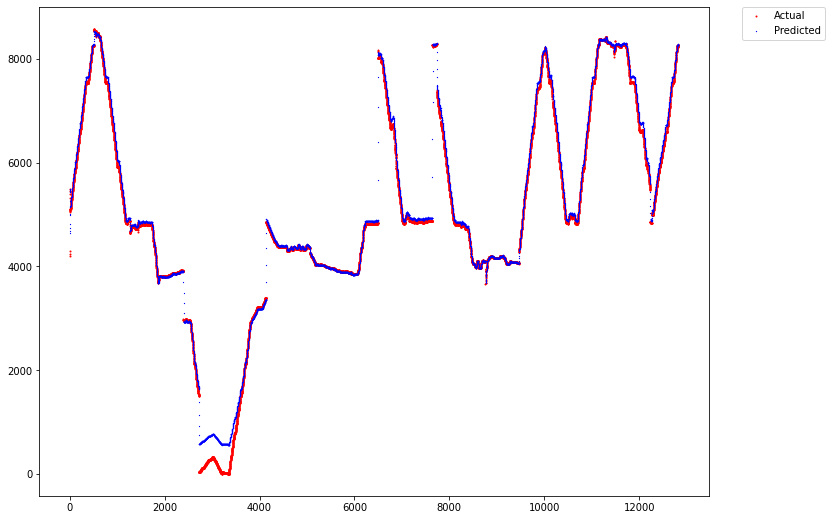

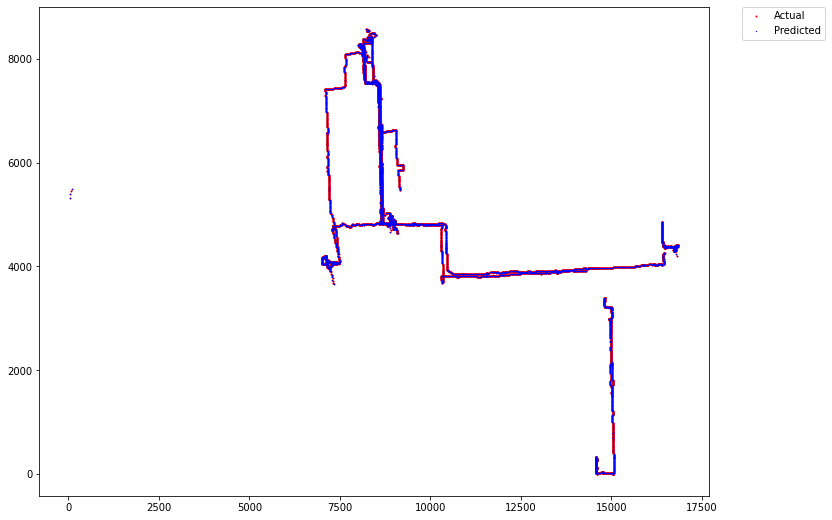

3 step forward
RMSE: 360.806421
RMSE for X in Train dataset: 699.535113
RMSE for Y in Train dataset: 106.110533
RMSE for X in Test dataset: 408.288176
RMSE for Y in Test dataset: 183.307833


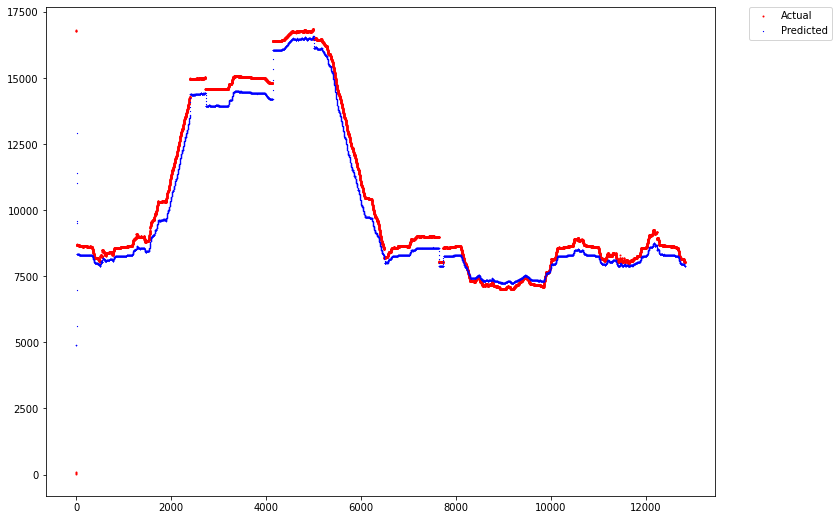

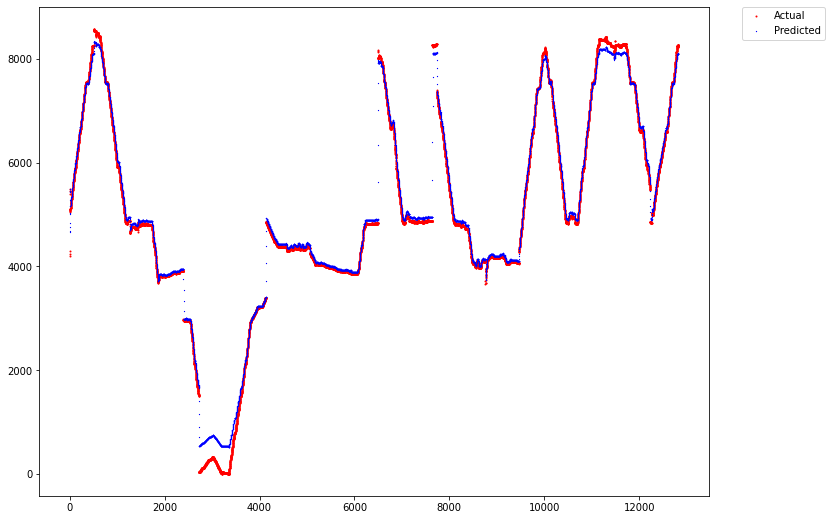

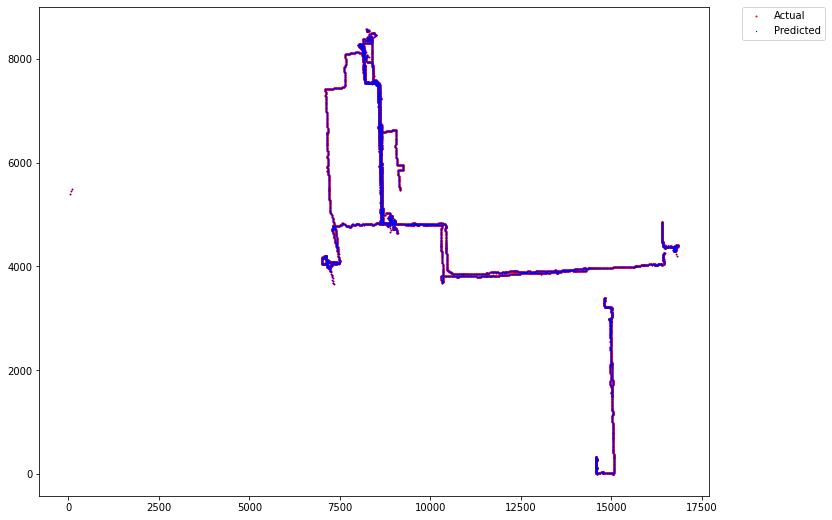

In [569]:
# make a prediction
yhatx = modelx.predict(test_X_1)

# invert scaling for forecast
inv_yhatx = scaler1.inverse_transform(yhatx)
# invert scaling for actual
inv_yx = scaler1.inverse_transform(test_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx, inv_yhatx))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhaty = modely.predict(test_X_2)

# invert scaling for forecast
inv_yhaty = scaler2.inverse_transform(yhaty)
# invert scaling for actual
inv_yy = scaler2.inverse_transform(test_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy, inv_yhaty))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhatx2 = modelx.predict(train_X_1)

# invert scaling for forecast
inv_yhatx2 = scaler1.inverse_transform(yhatx2)
# invert scaling for actual
inv_yx2 = scaler1.inverse_transform(train_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx2, inv_yhatx2))
print('Train RMSE: %.6f' % rmse)

# make a prediction
yhaty2 = modely.predict(train_X_2)

# invert scaling for forecast
inv_yhaty2 = scaler2.inverse_transform(yhaty2)
# invert scaling for actual
inv_yy2 = scaler2.inverse_transform(train_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy2, inv_yhaty2))
print('Train RMSE: %.6f' % rmse)

# 1 step forward

df_marks2 = pd.DataFrame(inv_yhatx2[:,0],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,0])

df_marks = pd.DataFrame(inv_yhatx[:,0],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,0])


df_marks3 = pd.DataFrame(inv_yx2[:,0],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,0])

df_marks4 = pd.DataFrame(inv_yx[:,0],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,0])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


print("1 step forward")
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 2 step forward
print("2 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,1],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,1])

df_marks = pd.DataFrame(inv_yhatx[:,1],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,1])


df_marks3 = pd.DataFrame(inv_yx2[:,1],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,1])

df_marks4 = pd.DataFrame(inv_yx[:,1],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,1])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)



# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 3 step forward
print("3 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,2],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,2])

df_marks = pd.DataFrame(inv_yhatx[:,2],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,2])


df_marks3 = pd.DataFrame(inv_yx2[:,2],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,2])

df_marks4 = pd.DataFrame(inv_yx[:,2],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,2])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train bidirectional LSTM models for each X coordinate and Y coordinate

Epoch 1/600
36/36 - 7s - loss: 0.0774 - accuracy: 0.3846 - val_loss: 0.0891 - val_accuracy: 0.2385
Epoch 2/600
36/36 - 0s - loss: 0.0614 - accuracy: 0.3390 - val_loss: 0.0173 - val_accuracy: 0.6134
Epoch 3/600
36/36 - 0s - loss: 0.0162 - accuracy: 0.3804 - val_loss: 0.0216 - val_accuracy: 0.5208
Epoch 4/600
36/36 - 0s - loss: 0.0175 - accuracy: 0.4108 - val_loss: 0.0168 - val_accuracy: 0.4488
Epoch 5/600
36/36 - 0s - loss: 0.0148 - accuracy: 0.3480 - val_loss: 0.0263 - val_accuracy: 0.2554
Epoch 6/600
36/36 - 0s - loss: 0.0267 - accuracy: 0.2658 - val_loss: 0.0301 - val_accuracy: 0.1729
Epoch 7/600
36/36 - 0s - loss: 0.0218 - accuracy: 0.3811 - val_loss: 0.0266 - val_accuracy: 0.2951
Epoch 8/600
36/36 - 0s - loss: 0.0249 - accuracy: 0.3675 - val_loss: 0.0250 - val_accuracy: 0.1042
Epoch 9/600
36/36 - 0s - loss: 0.0238 - accuracy: 0.1906 - val_loss: 0.0241 - val_accuracy: 0.2831
Epoch 10/600
36/36 - 0s - loss: 0.0165 - accuracy: 0.3675 - val_loss: 0.0243 - val_accuracy: 0.2076
Epoch 11/

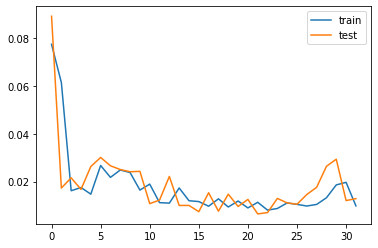

Epoch 1/600
36/36 - 8s - loss: 0.2696 - accuracy: 0.4096 - val_loss: 0.1568 - val_accuracy: 0.4354
Epoch 2/600
36/36 - 0s - loss: 0.0720 - accuracy: 0.3293 - val_loss: 0.0453 - val_accuracy: 0.3760
Epoch 3/600
36/36 - 0s - loss: 0.0356 - accuracy: 0.5643 - val_loss: 0.0548 - val_accuracy: 0.4931
Epoch 4/600
36/36 - 0s - loss: 0.0349 - accuracy: 0.2514 - val_loss: 0.0204 - val_accuracy: 0.1308
Epoch 5/600
36/36 - 0s - loss: 0.0187 - accuracy: 0.3157 - val_loss: 0.0455 - val_accuracy: 0.3908
Epoch 6/600
36/36 - 0s - loss: 0.0207 - accuracy: 0.3500 - val_loss: 0.0271 - val_accuracy: 0.4915
Epoch 7/600
36/36 - 0s - loss: 0.0163 - accuracy: 0.3371 - val_loss: 0.0102 - val_accuracy: 0.3601
Epoch 8/600
36/36 - 0s - loss: 0.0133 - accuracy: 0.4287 - val_loss: 0.0113 - val_accuracy: 0.2918
Epoch 9/600
36/36 - 0s - loss: 0.0142 - accuracy: 0.3172 - val_loss: 0.0160 - val_accuracy: 0.5595
Epoch 10/600
36/36 - 0s - loss: 0.0164 - accuracy: 0.4209 - val_loss: 0.0241 - val_accuracy: 0.1195
Epoch 11/

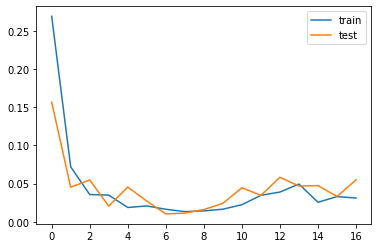

In [570]:
from keras.layers import Bidirectional

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modelx = Sequential()
modelx.add(Bidirectional(LSTM(150, input_shape=(train_X_1.shape[1], train_X_1.shape[2]))))
modelx.add(Dropout(0.1))
modelx.add(Dense(test_y_1.shape[1]))
modelx.compile(loss='mae', optimizer='adam',metrics=['accuracy'])


# fit network
historyx = modelx.fit(train_X_1, train_y_1, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_1, test_y_1), verbose=2, shuffle=False)
modelx.summary()
# plot history
pyplot.plot(historyx.history['loss'], label='train')
pyplot.plot(historyx.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

from keras.layers import Bidirectional

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modely = Sequential()
modely.add(Bidirectional(LSTM(150, input_shape=(train_X_2.shape[1], train_X_2.shape[2]))))
modely.add(Dropout(0.1))
modely.add(Dense(test_y_2.shape[1]))
modely.compile(loss='mae', optimizer='adam',metrics=['accuracy'])


# fit network
historyy = modely.fit(train_X_2, train_y_2, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_2, test_y_2), verbose=2, shuffle=False)
modely.summary()
# plot history
pyplot.plot(historyy.history['loss'], label='train')
pyplot.plot(historyy.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of bidirectional LSTM model for both X and Y models

In [571]:
yhat = modelx.predict(test_X_1)
_, accuracy = modelx.evaluate(test_X_1, test_y_1)
print('Accuracy of X model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_1, yhat))
print('Test RMSE: %.6f' % rmse)

yhat = modelx.predict(test_X_2)
_, accuracy = modelx.evaluate(test_X_2, test_y_2)
print('Accuracy of Y model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_2, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.3557
Accuracy of X model: 35.5709
Test RMSE: 0.010751
321/321 [==============================] - 0s 1ms/step - loss: 0.0104 - accuracy: 0.4213
Accuracy of Y model: 42.1278
Test RMSE: 0.025359


# Print error distance by RMSE metric and Plot the actual data vs predicted data for 1,2 and 3 step forwards

Test RMSE: 90.612111
Test RMSE: 110.780307
Train RMSE: 549.228664
Train RMSE: 68.757049
RMSE: 178.989050
1 step forward
RMSE for X in Train dataset: 465.471955
RMSE for Y in Train dataset: 59.576265
RMSE for X in Test dataset: 114.050055
RMSE for Y in Test dataset: 109.690042


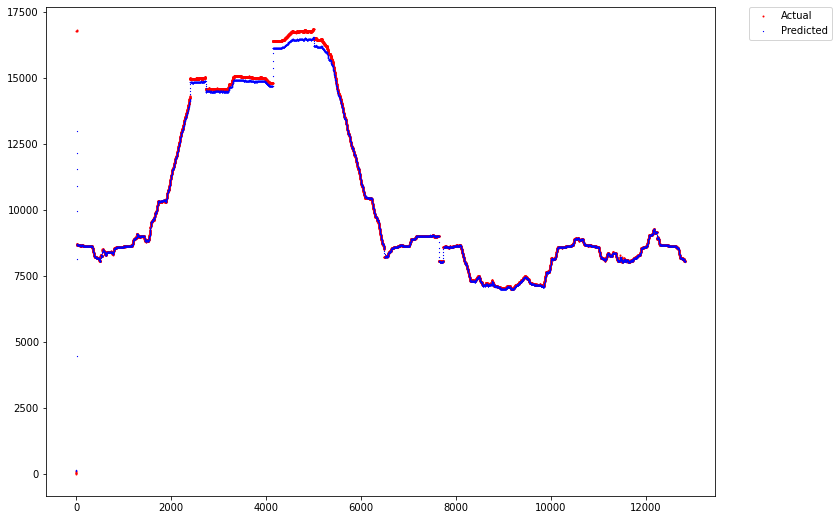

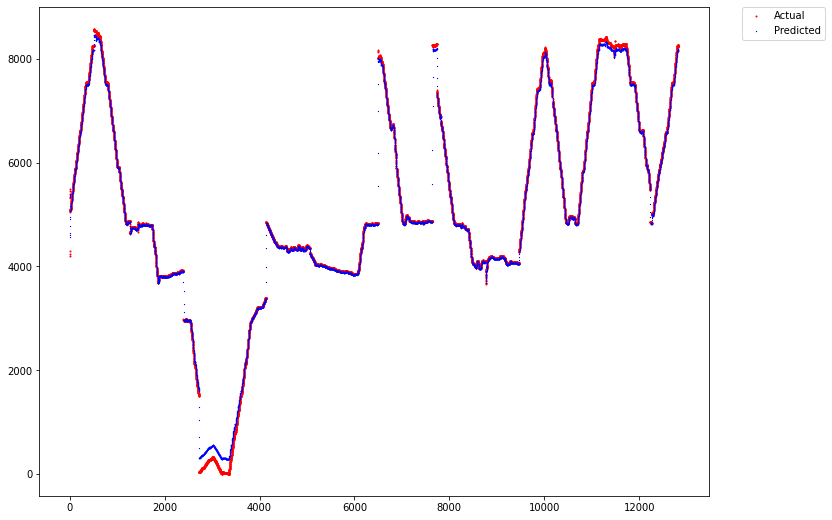

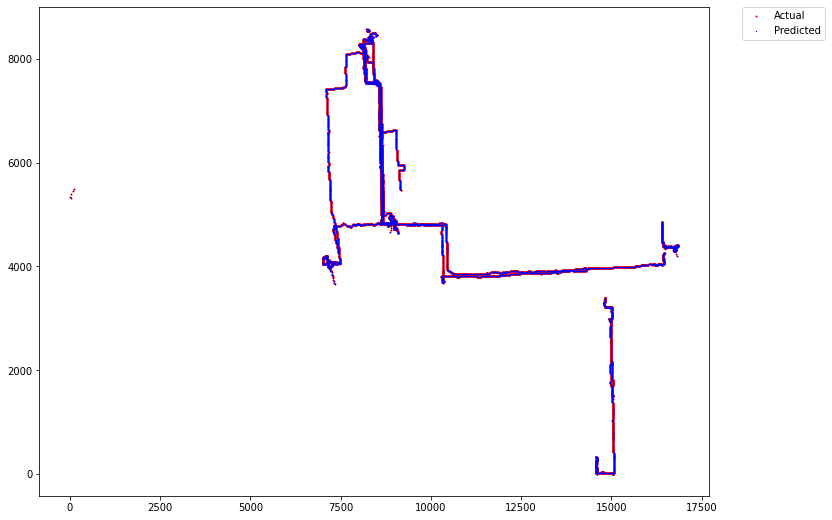

2 step forward
RMSE: 194.909244
RMSE for X in Train dataset: 559.487628
RMSE for Y in Train dataset: 61.536807
RMSE for X in Test dataset: 74.311199
RMSE for Y in Test dataset: 101.235310


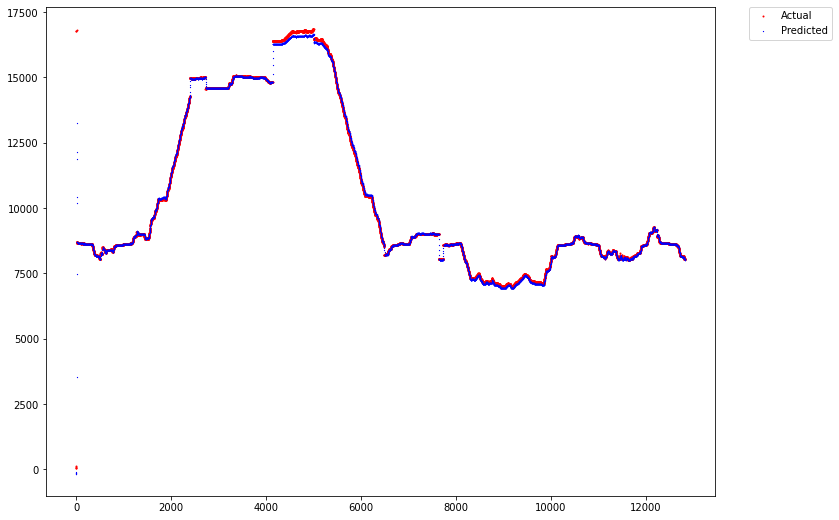

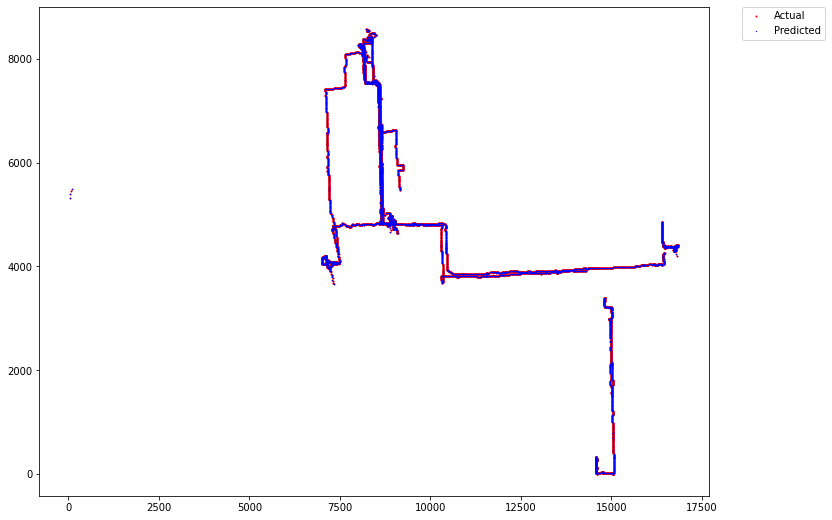

3 step forward
RMSE: 215.562310
RMSE for X in Train dataset: 612.592952
RMSE for Y in Train dataset: 82.743459
RMSE for X in Test dataset: 78.116715
RMSE for Y in Test dataset: 120.566983


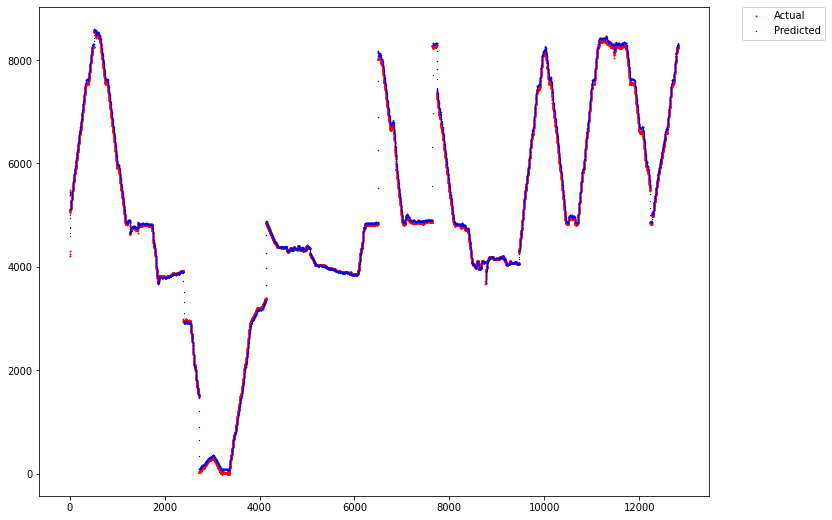

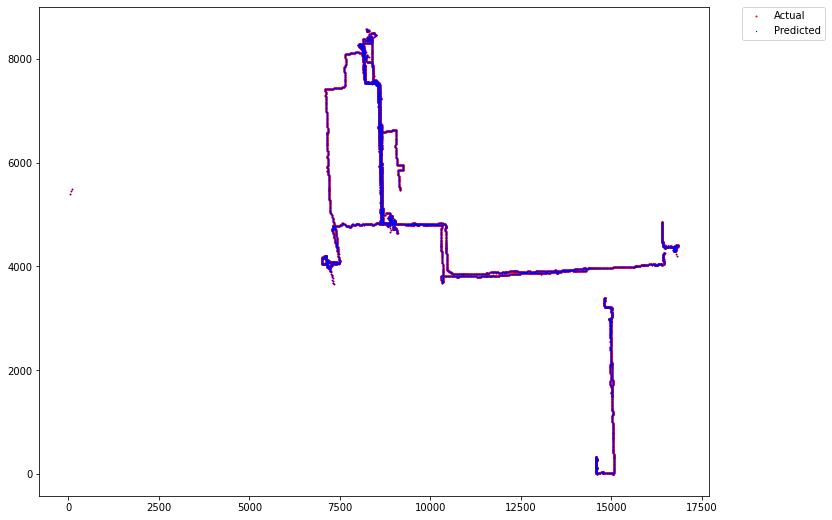

In [573]:
# make a prediction
yhatx = modelx.predict(test_X_1)

# invert scaling for forecast
inv_yhatx = scaler1.inverse_transform(yhatx)
# invert scaling for actual
inv_yx = scaler1.inverse_transform(test_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx, inv_yhatx))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhaty = modely.predict(test_X_2)

# invert scaling for forecast
inv_yhaty = scaler2.inverse_transform(yhaty)
# invert scaling for actual
inv_yy = scaler2.inverse_transform(test_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy, inv_yhaty))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhatx2 = modelx.predict(train_X_1)

# invert scaling for forecast
inv_yhatx2 = scaler1.inverse_transform(yhatx2)
# invert scaling for actual
inv_yx2 = scaler1.inverse_transform(train_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx2, inv_yhatx2))
print('Train RMSE: %.6f' % rmse)

# make a prediction
yhaty2 = modely.predict(train_X_2)

# invert scaling for forecast
inv_yhaty2 = scaler2.inverse_transform(yhaty2)
# invert scaling for actual
inv_yy2 = scaler2.inverse_transform(train_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy2, inv_yhaty2))
print('Train RMSE: %.6f' % rmse)

# 1 step forward

df_marks2 = pd.DataFrame(inv_yhatx2[:,0],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,0])

df_marks = pd.DataFrame(inv_yhatx[:,0],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,0])


df_marks3 = pd.DataFrame(inv_yx2[:,0],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,0])

df_marks4 = pd.DataFrame(inv_yx[:,0],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,0])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


print("1 step forward")
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 2 step forward
print("2 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,1],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,1])

df_marks = pd.DataFrame(inv_yhatx[:,1],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,1])


df_marks3 = pd.DataFrame(inv_yx2[:,1],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,1])

df_marks4 = pd.DataFrame(inv_yx[:,1],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,1])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)



# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 3 step forward
print("3 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,2],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,2])

df_marks = pd.DataFrame(inv_yhatx[:,2],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,2])


df_marks3 = pd.DataFrame(inv_yx2[:,2],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,2])

df_marks4 = pd.DataFrame(inv_yx[:,2],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,2])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train GRU models for each X coordinate and Y coordinate

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, 64)                13632     
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 3)                 195       
Total params: 13,827
Trainable params: 13,827
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 4s - loss: 0.0937 - accuracy: 0.4482 - val_loss: 0.1391 - val_accuracy: 0.3300
Epoch 2/600
36/36 - 0s - loss: 0.0649 - accuracy: 0.4135 - val_loss: 0.0259 - val_accuracy: 0.2443
Epoch 3/600
36/36 - 0s - loss: 0.0264 - accuracy: 0.2299 - val_loss: 0.0382 - val_accuracy: 0.2828
Epoch 4/600
36/36 - 0s - loss: 0.0315 - accuracy: 0.2896 - val_loss: 0.0380 - val_

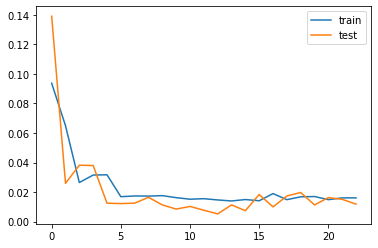

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 64)                13632     
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 3)                 195       
Total params: 13,827
Trainable params: 13,827
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 4s - loss: 0.2862 - accuracy: 0.4493 - val_loss: 0.2072 - val_accuracy: 0.4293
Epoch 2/600
36/36 - 0s - loss: 0.1390 - accuracy: 0.3963 - val_loss: 0.0681 - val_accuracy: 0.4134
Epoch 3/600
36/36 - 0s - loss: 0.0349 - accuracy: 0.2627 - val_loss: 0.0414 - val_accuracy: 0.5634
Epoch 4/600
36/36 - 0s - loss: 0.0332 - accuracy: 0.2954 - val_loss: 0.0351 - val_

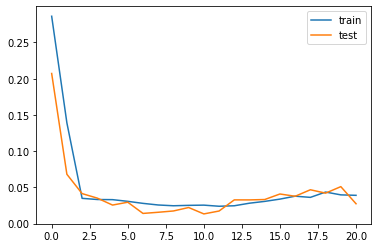

In [577]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modelx = Sequential()
modelx.add(GRU(64, input_shape=(train_X_1.shape[1], train_X_1.shape[2])))
modelx.add(Dropout(0.1))
modelx.add(Dense(test_y_1.shape[1]))
modelx.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modelx.summary()
# fit network
historyx = modelx.fit(train_X_1, train_y_1, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_1, test_y_1), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyx.history['loss'], label='train')
pyplot.plot(historyx.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modely = Sequential()
modely.add(GRU(64, input_shape=(train_X_2.shape[1], train_X_2.shape[2])))
modely.add(Dropout(0.1))
modely.add(Dense(test_y_2.shape[1]))
modely.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modely.summary()
# fit network
historyy = modely.fit(train_X_2, train_y_2, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_2, test_y_2), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyy.history['loss'], label='train')
pyplot.plot(historyy.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of GRU model for both X and Y models

In [578]:
yhat = modelx.predict(test_X_1)
_, accuracy = modelx.evaluate(test_X_1, test_y_1)
print('Accuracy of X model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_1, yhat))
print('Test RMSE: %.6f' % rmse)

yhat = modelx.predict(test_X_2)
_, accuracy = modelx.evaluate(test_X_2, test_y_2)
print('Accuracy of Y model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_2, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.4627
Accuracy of X model: 46.2685
Test RMSE: 0.008220
321/321 [==============================] - 0s 1ms/step - loss: 0.0154 - accuracy: 0.4348
Accuracy of Y model: 43.4821
Test RMSE: 0.037881


# Print error distance by RMSE metric and Plot the actual data vs predicted data for 1,2 and 3 step forwards

Test RMSE: 69.282106
Test RMSE: 130.368596
Train RMSE: 517.398662
Train RMSE: 109.121850
RMSE: 168.607058
1 step forward
RMSE for X in Train dataset: 469.128864
RMSE for Y in Train dataset: 57.289015
RMSE for X in Test dataset: 86.903621
RMSE for Y in Test dataset: 87.622108


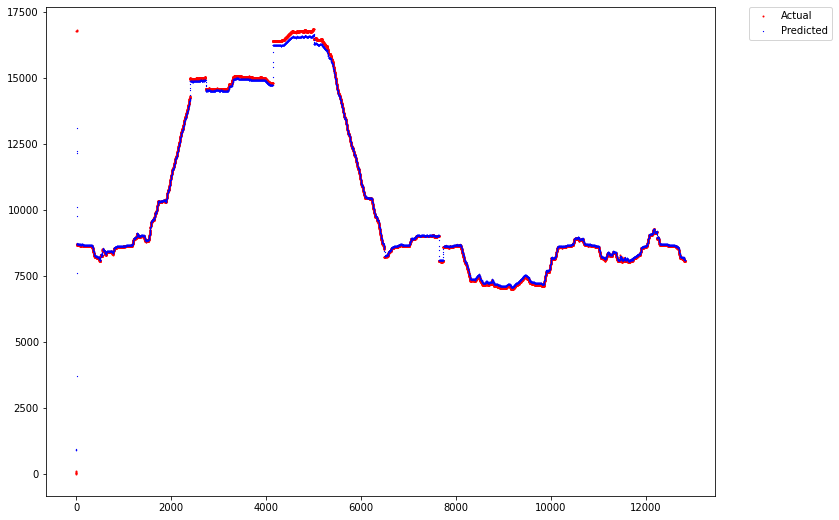

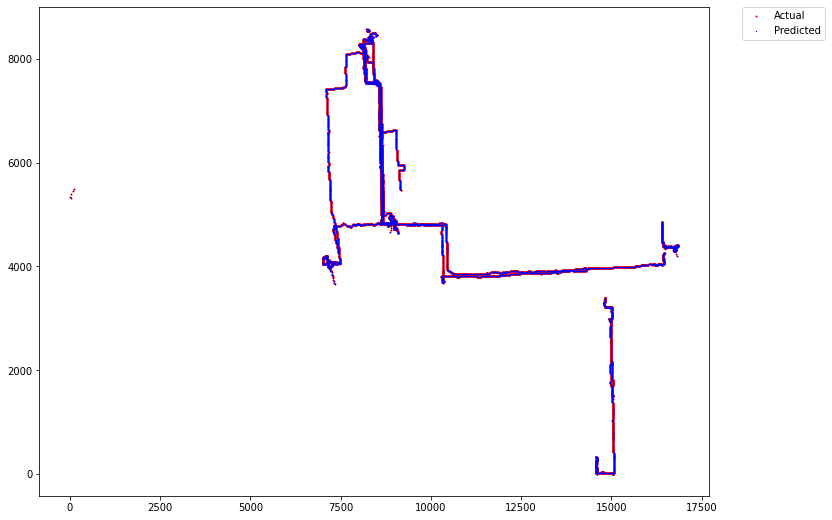

2 step forward
RMSE: 184.936349
RMSE for X in Train dataset: 521.913157
RMSE for Y in Train dataset: 76.830713
RMSE for X in Test dataset: 62.504715
RMSE for Y in Test dataset: 109.648146


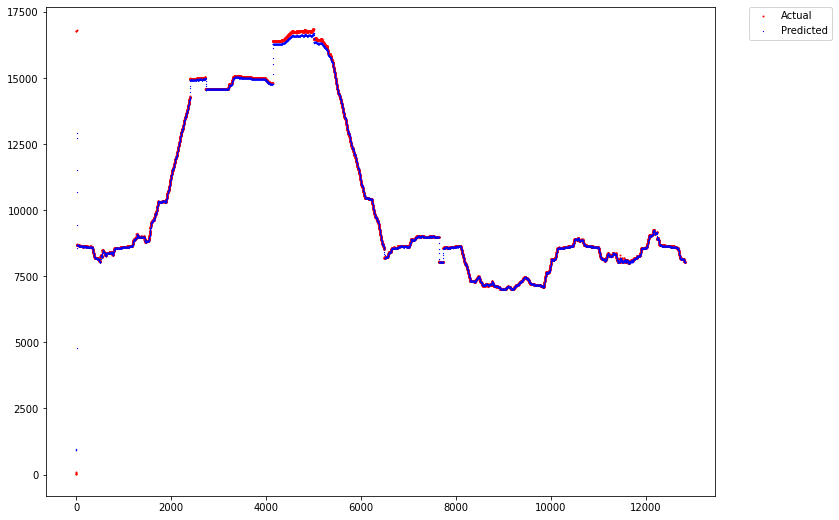

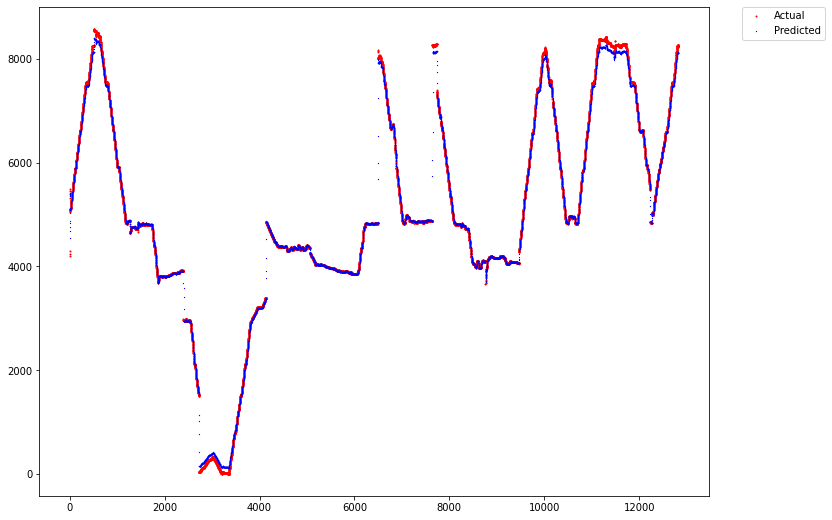

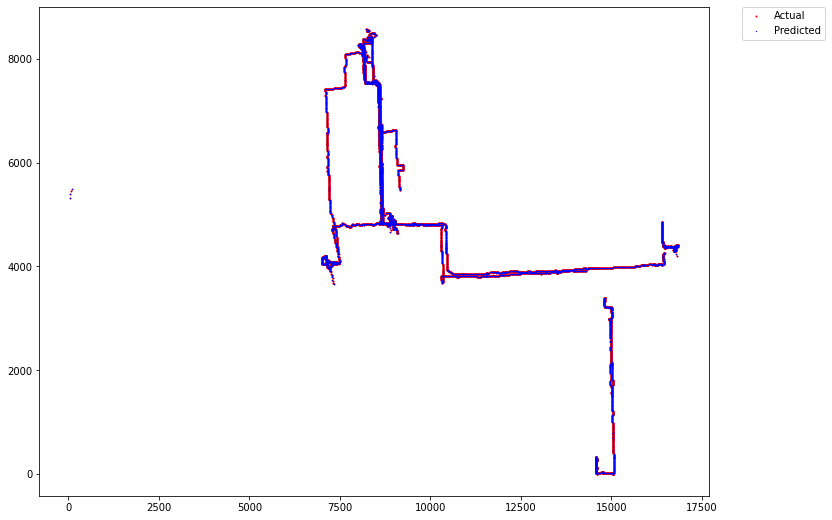

3 step forward
RMSE: 217.734348
RMSE for X in Train dataset: 557.341794
RMSE for Y in Train dataset: 162.904137
RMSE for X in Test dataset: 54.231120
RMSE for Y in Test dataset: 176.883254


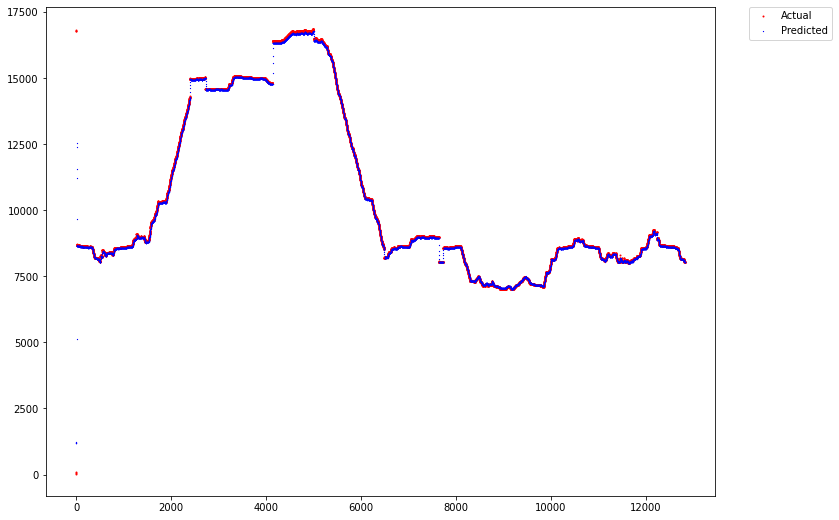

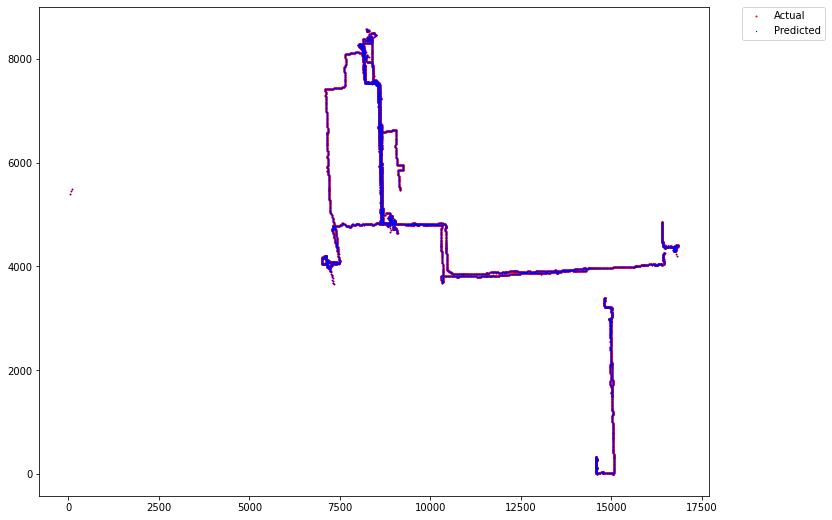

In [581]:
# make a prediction
yhatx = modelx.predict(test_X_1)

# invert scaling for forecast
inv_yhatx = scaler1.inverse_transform(yhatx)
# invert scaling for actual
inv_yx = scaler1.inverse_transform(test_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx, inv_yhatx))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhaty = modely.predict(test_X_2)

# invert scaling for forecast
inv_yhaty = scaler2.inverse_transform(yhaty)
# invert scaling for actual
inv_yy = scaler2.inverse_transform(test_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy, inv_yhaty))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhatx2 = modelx.predict(train_X_1)

# invert scaling for forecast
inv_yhatx2 = scaler1.inverse_transform(yhatx2)
# invert scaling for actual
inv_yx2 = scaler1.inverse_transform(train_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx2, inv_yhatx2))
print('Train RMSE: %.6f' % rmse)

# make a prediction
yhaty2 = modely.predict(train_X_2)

# invert scaling for forecast
inv_yhaty2 = scaler2.inverse_transform(yhaty2)
# invert scaling for actual
inv_yy2 = scaler2.inverse_transform(train_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy2, inv_yhaty2))
print('Train RMSE: %.6f' % rmse)

# 1 step forward

df_marks2 = pd.DataFrame(inv_yhatx2[:,0],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,0])

df_marks = pd.DataFrame(inv_yhatx[:,0],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,0])


df_marks3 = pd.DataFrame(inv_yx2[:,0],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,0])

df_marks4 = pd.DataFrame(inv_yx[:,0],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,0])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


print("1 step forward")
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 2 step forward
print("2 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,1],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,1])

df_marks = pd.DataFrame(inv_yhatx[:,1],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,1])


df_marks3 = pd.DataFrame(inv_yx2[:,1],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,1])

df_marks4 = pd.DataFrame(inv_yx[:,1],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,1])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)



# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 3 step forward
print("3 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,2],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,2])

df_marks = pd.DataFrame(inv_yhatx[:,2],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,2])


df_marks3 = pd.DataFrame(inv_yx2[:,2],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,2])

df_marks4 = pd.DataFrame(inv_yx[:,2],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,2])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train stacked GRUs models for each X coordinate and Y coordinate

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_39 (GRU)                 (None, 1, 32)             3744      
_________________________________________________________________
gru_40 (GRU)                 (None, 64)                18816     
_________________________________________________________________
dropout_84 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 3)                 195       
Total params: 22,755
Trainable params: 22,755
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 6s - loss: 0.1025 - accuracy: 0.3757 - val_loss: 0.1678 - val_accuracy: 0.3287
Epoch 2/600
36/36 - 0s - loss: 0.0821 - accuracy: 0.3585 - val_loss: 0.0248 - val_accuracy: 0.6127
Epoch 3/600
36/36 - 0s - loss: 0.0177 - accuracy:

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_41 (GRU)                 (None, 1, 32)             3744      
_________________________________________________________________
gru_42 (GRU)                 (None, 64)                18816     
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 3)                 195       
Total params: 22,755
Trainable params: 22,755
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 6s - loss: 0.1040 - accuracy: 0.3679 - val_loss: 0.1656 - val_accuracy: 0.5588
Epoch 2/600
36/36 - 0s - loss: 0.0830 - accuracy: 0.4345 - val_loss: 0.0324 - val_accuracy: 0.2554
Epoch 3/600
36/36 - 0s - loss: 0.0245 - accuracy:

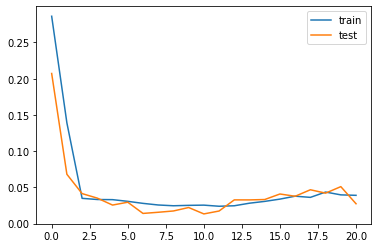

In [593]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modelx = Sequential()
modelx.add(GRU(32,return_sequences=True, activation='tanh', input_shape=(train_X_1.shape[1], train_X_1.shape[2])))

modelx.add(GRU(units=64, activation='tanh',return_sequences=False))
modelx.add(Dropout(0.1))
modelx.add(Dense(test_y_1.shape[1]))
modelx.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modelx.summary()

# fit network
historyx = modelx.fit(train_X_1, train_y_1, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_1, test_y_1), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyx.history['loss'], label='train')
pyplot.plot(historyx.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modely = Sequential()
modely.add(GRU(32,return_sequences=True, activation='tanh', input_shape=(train_X_2.shape[1], train_X_2.shape[2])))

modely.add(GRU(units=64, activation='tanh',return_sequences=False))
modely.add(Dropout(0.1))
modely.add(Dense(test_y_2.shape[1]))
modely.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modely.summary()

# fit network
historyu = modely.fit(train_X_1, train_y_1, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_1, test_y_1), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyy.history['loss'], label='train')
pyplot.plot(historyy.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of stacked GRU model for both X and Y models

In [594]:
yhat = modelx.predict(test_X_1)
_, accuracy = modelx.evaluate(test_X_1, test_y_1)
print('Accuracy of X model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_1, yhat))
print('Test RMSE: %.6f' % rmse)

yhat = modelx.predict(test_X_2)
_, accuracy = modelx.evaluate(test_X_2, test_y_2)
print('Accuracy of Y model: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_2, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 0.4868
Accuracy of X model: 48.6847
Test RMSE: 0.012707
321/321 [==============================] - 0s 1ms/step - loss: 0.0358 - accuracy: 0.4984
Accuracy of Y model: 49.8441
Test RMSE: 0.087923


# Print error distance by RMSE metric and Plot the actual data vs predicted data for 1,2 and 3 step forwards

Test RMSE: 107.100402
Test RMSE: 485.910277
Train RMSE: 492.351548
Train RMSE: 106.468525
RMSE: 371.695545
1 step forward
RMSE for X in Train dataset: 459.250731
RMSE for Y in Train dataset: 111.919378
RMSE for X in Test dataset: 141.342496
RMSE for Y in Test dataset: 519.188730


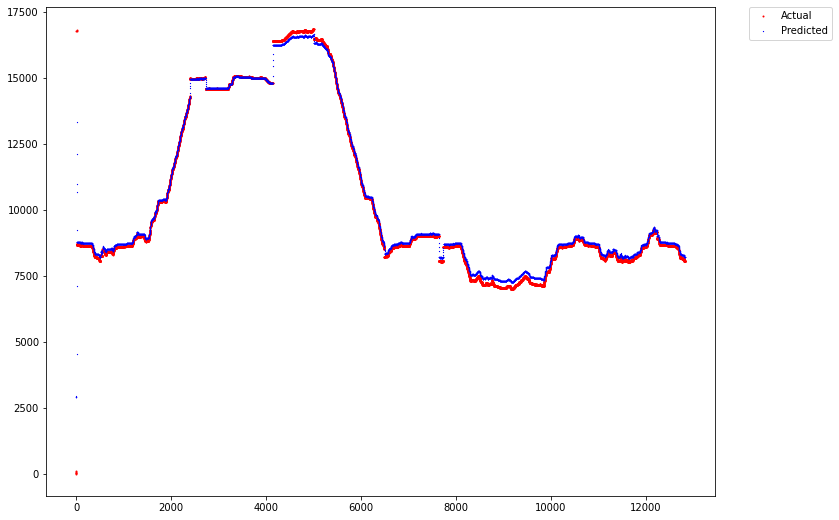

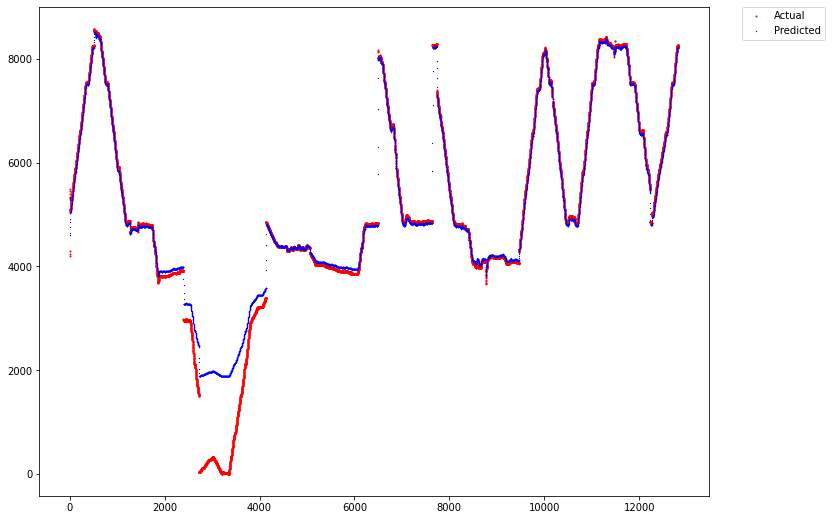

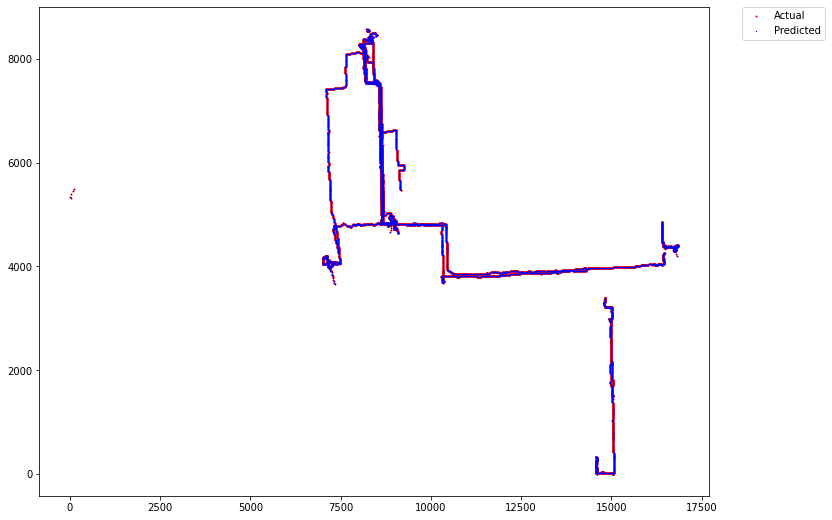

2 step forward
RMSE: 339.572157
RMSE for X in Train dataset: 493.376393
RMSE for Y in Train dataset: 101.774975
RMSE for X in Test dataset: 90.865881
RMSE for Y in Test dataset: 465.372902


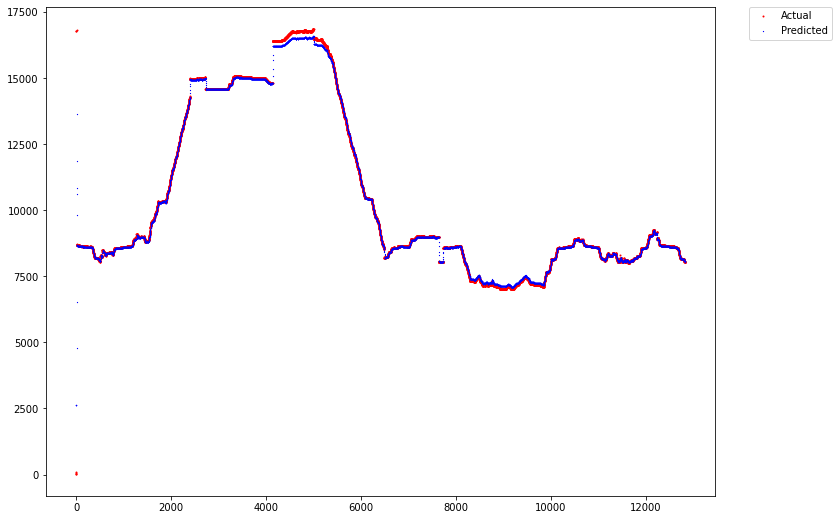

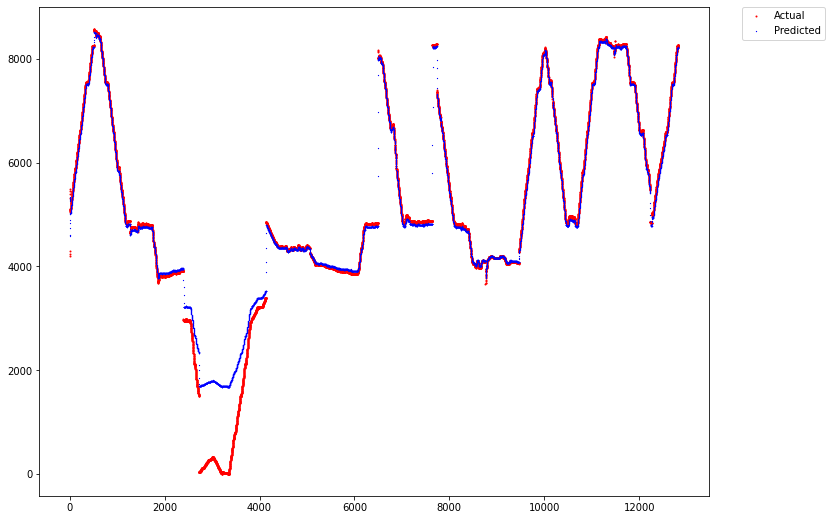

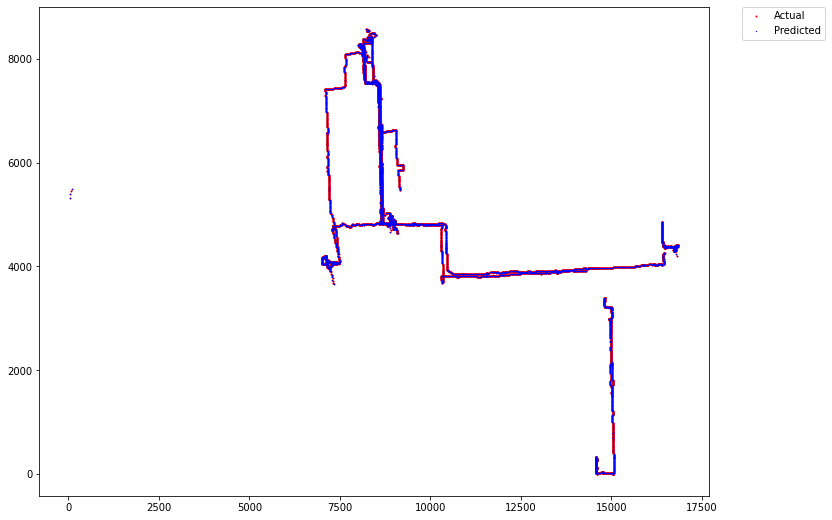

3 step forward
RMSE: 346.054345
RMSE for X in Train dataset: 522.400319
RMSE for Y in Train dataset: 105.463430
RMSE for X in Test dataset: 78.595434
RMSE for Y in Test dataset: 471.381613


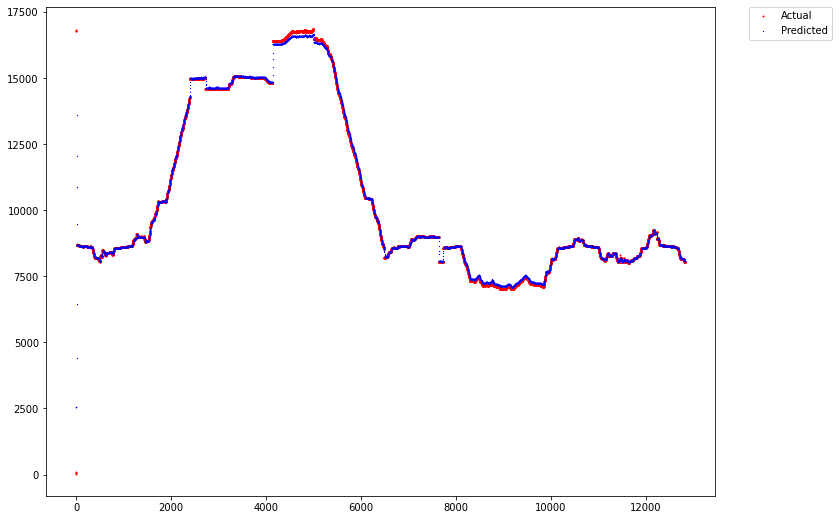

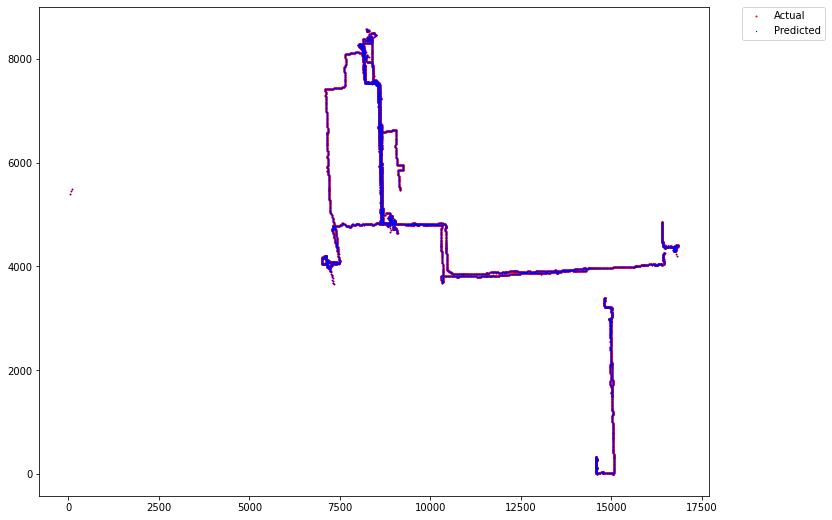

In [595]:
# make a prediction
yhatx = modelx.predict(test_X_1)

# invert scaling for forecast
inv_yhatx = scaler1.inverse_transform(yhatx)
# invert scaling for actual
inv_yx = scaler1.inverse_transform(test_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx, inv_yhatx))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhaty = modely.predict(test_X_2)

# invert scaling for forecast
inv_yhaty = scaler2.inverse_transform(yhaty)
# invert scaling for actual
inv_yy = scaler2.inverse_transform(test_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy, inv_yhaty))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhatx2 = modelx.predict(train_X_1)

# invert scaling for forecast
inv_yhatx2 = scaler1.inverse_transform(yhatx2)
# invert scaling for actual
inv_yx2 = scaler1.inverse_transform(train_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx2, inv_yhatx2))
print('Train RMSE: %.6f' % rmse)

# make a prediction
yhaty2 = modely.predict(train_X_2)

# invert scaling for forecast
inv_yhaty2 = scaler2.inverse_transform(yhaty2)
# invert scaling for actual
inv_yy2 = scaler2.inverse_transform(train_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy2, inv_yhaty2))
print('Train RMSE: %.6f' % rmse)

# 1 step forward

df_marks2 = pd.DataFrame(inv_yhatx2[:,0],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,0])

df_marks = pd.DataFrame(inv_yhatx[:,0],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,0])


df_marks3 = pd.DataFrame(inv_yx2[:,0],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,0])

df_marks4 = pd.DataFrame(inv_yx[:,0],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,0])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


print("1 step forward")
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 2 step forward
print("2 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,1],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,1])

df_marks = pd.DataFrame(inv_yhatx[:,1],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,1])


df_marks3 = pd.DataFrame(inv_yx2[:,1],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,1])

df_marks4 = pd.DataFrame(inv_yx[:,1],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,1])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)



# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 3 step forward
print("3 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,2],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,2])

df_marks = pd.DataFrame(inv_yhatx[:,2],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,2])


df_marks3 = pd.DataFrame(inv_yx2[:,2],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,2])

df_marks4 = pd.DataFrame(inv_yx[:,2],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,2])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train RNN models for each X coordinate and Y coordinate

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 64)                4480      
_________________________________________________________________
dropout_65 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 3)                 195       
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 3s - loss: 0.0685 - accuracy: 0.2284 - val_loss: 0.0673 - val_accuracy: 0.3926
Epoch 2/600
36/36 - 0s - loss: 0.0734 - accuracy: 0.4150 - val_loss: 0.0412 - val_accuracy: 0.2675
Epoch 3/600
36/36 - 0s - loss: 0.0397 - accuracy: 0.2650 - val_loss: 0.0418 - val_accuracy: 0.2833
Epoch 4/600
36/36 - 0s - loss: 0.0434 - accuracy: 0.2923 - val_loss: 0.0275 - val_ac

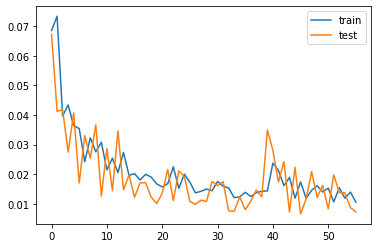

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 64)                4480      
_________________________________________________________________
dropout_66 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 3)                 195       
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
36/36 - 3s - loss: 0.1667 - accuracy: 0.2627 - val_loss: 0.0354 - val_accuracy: 0.3784
Epoch 2/600
36/36 - 0s - loss: 0.0551 - accuracy: 0.3780 - val_loss: 0.0273 - val_accuracy: 0.3556
Epoch 3/600
36/36 - 0s - loss: 0.0513 - accuracy: 0.3531 - val_loss: 0.0634 - val_accuracy: 0.3762
Epoch 4/600
36/36 - 0s - loss: 0.0553 - accuracy: 0.3488 - val_loss: 0.0217 - val_ac

In [545]:

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modelx = Sequential()
modelx.add(SimpleRNN(64, input_shape=(train_X_1.shape[1], train_X_1.shape[2])))
modelx.add(Dropout(0.1))
modelx.add(Dense(test_y_1.shape[1]))
modelx.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modelx.summary()

# fit network
historyx = modelx.fit(train_X_1, train_y_1, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_1, test_y_1), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyx.history['loss'], label='train')
pyplot.plot(historyx.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
modely = Sequential()
modely.add(SimpleRNN(64, input_shape=(train_X_2.shape[1], train_X_2.shape[2])))
modely.add(Dropout(0.1))
modely.add(Dense(test_y_2.shape[1]))
modely.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
modely.summary()

# fit network
historyy = modely.fit(train_X_2, train_y_2, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X_2, test_y_2), verbose=2, shuffle=False)

# plot history
pyplot.plot(historyy.history['loss'], label='train')
pyplot.plot(historyy.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of RNN model for both X and Y models

In [546]:
yhat = modelx.predict(test_X_1)
_, accuracy = modelx.evaluate(test_X_1, test_y_1)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_1, yhat))
print('Test RMSE: %.6f' % rmse)

yhat = modelx.predict(test_X_2)
_, accuracy = modelx.evaluate(test_X_2, test_y_2)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y_2, yhat))
print('Test RMSE: %.6f' % rmse)

321/321 [==============================] - 0s 984us/step - loss: 0.0066 - accuracy: 0.2832
Accuracy: 28.3223
Test RMSE: 0.008760
321/321 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.3703
Accuracy: 37.0323
Test RMSE: 0.021582


# Print error distance by RMSE metric and Plot the actual data vs predicted data for 1,2 and 3 step forwards

Test RMSE: 73.835620
Test RMSE: 144.727539
Train RMSE: 499.636164
Train RMSE: 101.497171
RMSE: 147.238825
1 step forward
RMSE for X in Train dataset: 380.182871
RMSE for Y in Train dataset: 85.085524
RMSE for X in Test dataset: 32.955053
RMSE for Y in Test dataset: 123.156389


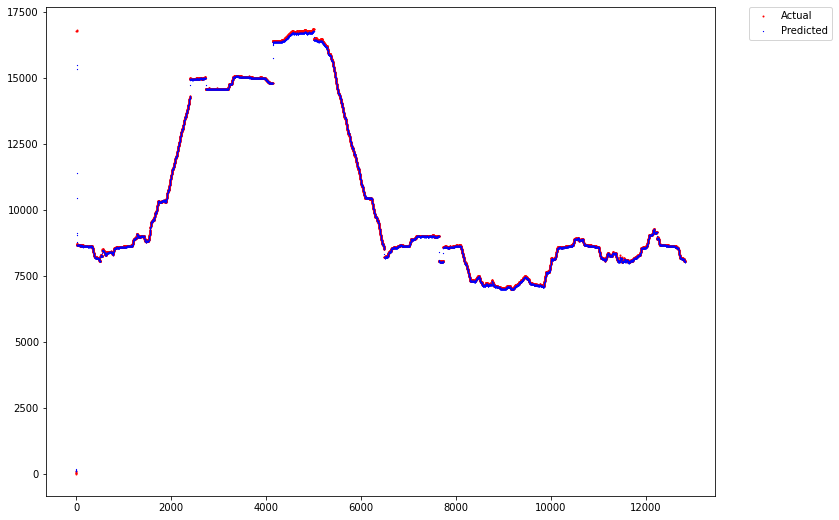

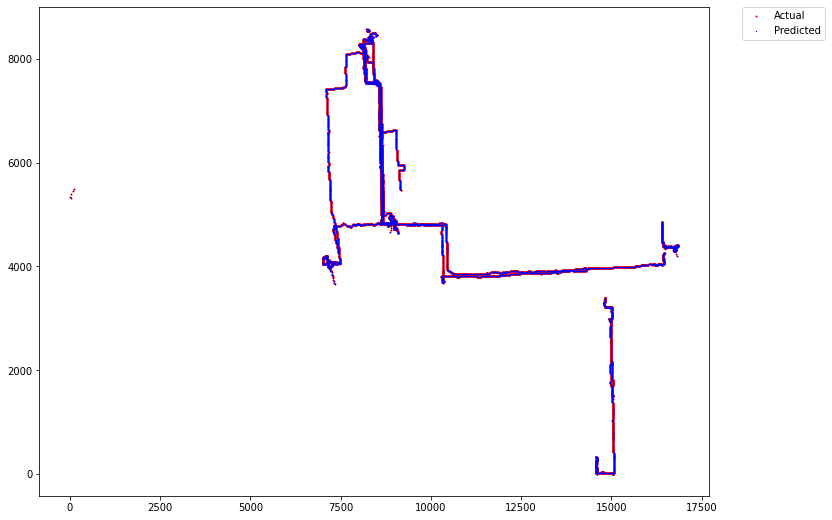

2 step forward
RMSE: 193.917347
RMSE for X in Train dataset: 507.803558
RMSE for Y in Train dataset: 105.948054
RMSE for X in Test dataset: 66.606452
RMSE for Y in Test dataset: 149.335429


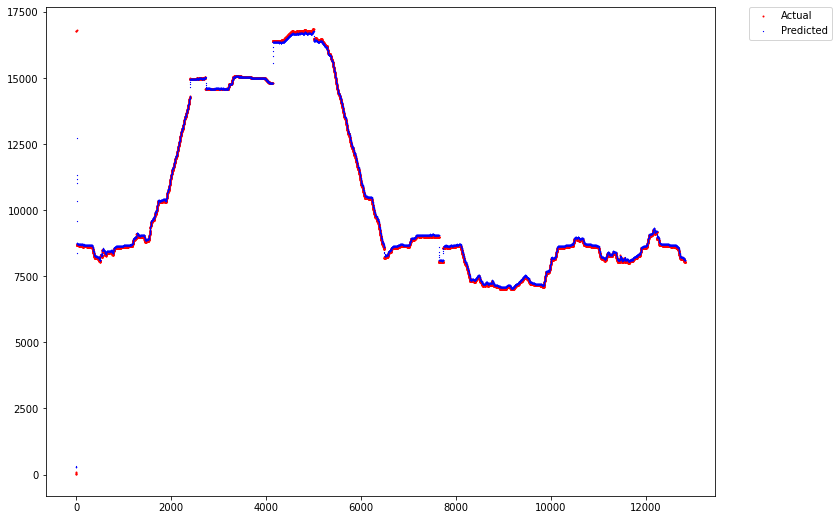

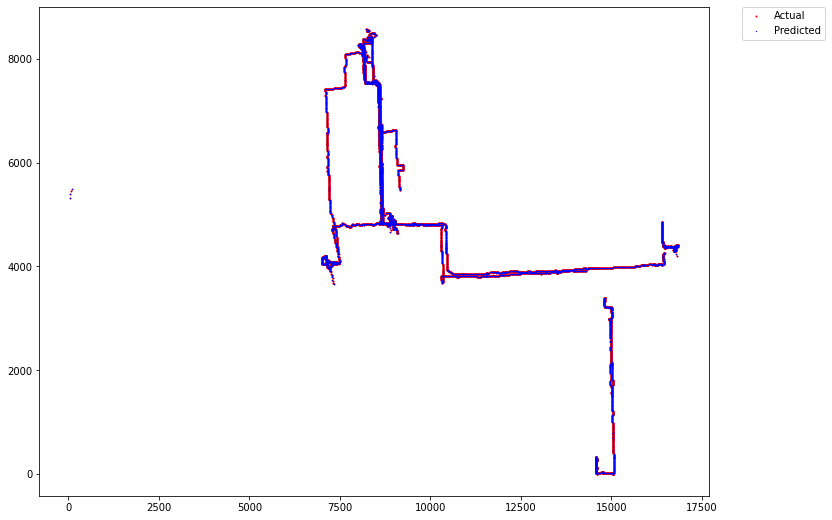

3 step forward
RMSE: 224.445288
RMSE for X in Train dataset: 588.648266
RMSE for Y in Train dataset: 111.536919
RMSE for X in Test dataset: 104.080075
RMSE for Y in Test dataset: 159.278862


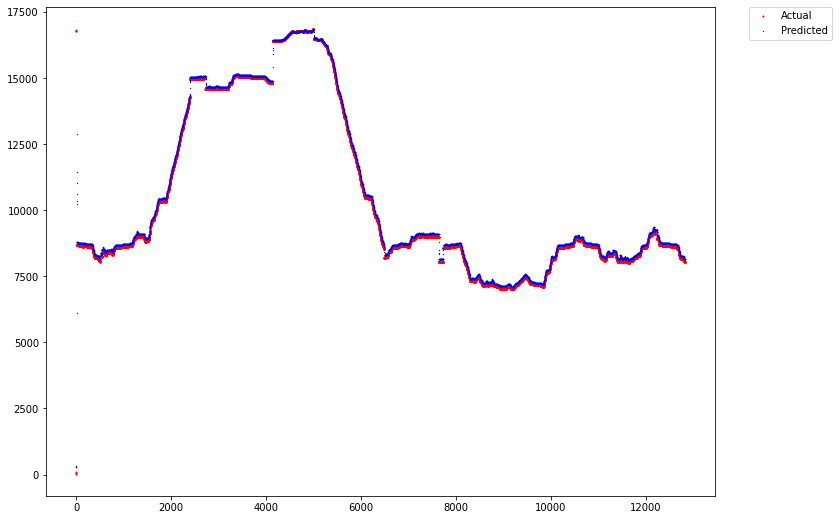

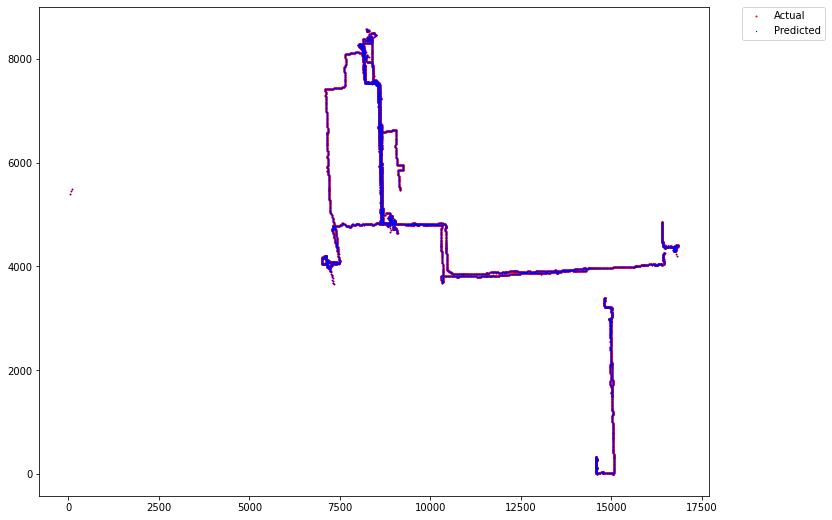

In [560]:
# make a prediction
yhatx = modelx.predict(test_X_1)

# invert scaling for forecast
inv_yhatx = scaler1.inverse_transform(yhatx)
# invert scaling for actual
inv_yx = scaler1.inverse_transform(test_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx, inv_yhatx))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhaty = modely.predict(test_X_2)

# invert scaling for forecast
inv_yhaty = scaler2.inverse_transform(yhaty)
# invert scaling for actual
inv_yy = scaler2.inverse_transform(test_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy, inv_yhaty))
print('Test RMSE: %.6f' % rmse)


# make a prediction
yhatx2 = modelx.predict(train_X_1)

# invert scaling for forecast
inv_yhatx2 = scaler1.inverse_transform(yhatx2)
# invert scaling for actual
inv_yx2 = scaler1.inverse_transform(train_y_1)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yx2, inv_yhatx2))
print('Train RMSE: %.6f' % rmse)

# make a prediction
yhaty2 = modely.predict(train_X_2)

# invert scaling for forecast
inv_yhaty2 = scaler2.inverse_transform(yhaty2)
# invert scaling for actual
inv_yy2 = scaler2.inverse_transform(train_y_2)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_yy2, inv_yhaty2))
print('Train RMSE: %.6f' % rmse)

# 1 step forward

df_marks2 = pd.DataFrame(inv_yhatx2[:,0],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,0])

df_marks = pd.DataFrame(inv_yhatx[:,0],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,0])


df_marks3 = pd.DataFrame(inv_yx2[:,0],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,0])

df_marks4 = pd.DataFrame(inv_yx[:,0],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,0])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


print("1 step forward")
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 2 step forward
print("2 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,1],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,1])

df_marks = pd.DataFrame(inv_yhatx[:,1],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,1])


df_marks3 = pd.DataFrame(inv_yx2[:,1],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,1])

df_marks4 = pd.DataFrame(inv_yx[:,1],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,1])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)



# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



# 3 step forward
print("3 step forward")
df_marks2 = pd.DataFrame(inv_yhatx2[:,2],columns=['X'])
df_marks2['Y'] = pd.DataFrame(inv_yhaty2[:,2])

df_marks = pd.DataFrame(inv_yhatx[:,2],columns=['X'])
df_marks['Y'] = pd.DataFrame(inv_yhaty[:,2])


df_marks3 = pd.DataFrame(inv_yx2[:,2],columns=['X'])
df_marks3['Y'] = pd.DataFrame(inv_yy2[:,2])

df_marks4 = pd.DataFrame(inv_yx[:,2],columns=['X'])
df_marks4['Y'] = pd.DataFrame(inv_yy[:,2])


inv_f = np.concatenate((df_marks2, df_marks), axis=0)
inv_f = pd.DataFrame(inv_f)


inv_o = np.concatenate((df_marks3, df_marks4), axis=0)
inv_o = pd.DataFrame(inv_o)
inv_f,inv_o
rmse = sqrt(mean_squared_error(inv_f,inv_o))
print('RMSE: %.6f' % rmse)


# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,0], df_marks3.iloc[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks2.iloc[:,1], df_marks3.iloc[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,0], df_marks4.iloc[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(df_marks.iloc[:,1], df_marks4.iloc[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Dataset generated from simulator

In [210]:
T1 = pd.read_csv('UE2_01-09-2021_20-39-42.csv', low_memory=False)
T2 = pd.read_csv('UE3_01-09-2021_20-39-42.csv', low_memory=False)
T3 = pd.read_csv('UE4_01-09-2021_20-39-42.csv', low_memory=False)

In [220]:
T1.iloc[:,0]

T1.columns = ['X', 'Y','Speed','Time']
T2.columns = ['X', 'Y','Speed','Time']
T3.columns = ['X', 'Y','Speed','Time']

# Initial Data Exploration, Data preparation and Plotting 3 Trajectories 

In [398]:
T1.head()

X           Y     Speed  Time
0  148.832079 -240.485966  4.517157     1
1  148.664153 -235.971996  4.517093     2
2  148.496217 -231.458154  4.516965     3
3  148.328266 -226.944504  4.516773     4
4  148.160295 -222.431111  4.516517     5

In [489]:
T1.describe(),T2.describe(),T3.describe()

(                 X            Y        Speed         Time
 count  3399.000000  3399.000000  3399.000000  3399.000000
 mean     63.174754   -29.067913     3.224978  1700.000000
 std     432.108042   551.068725     0.915406   981.351109
 min    -812.458685  -878.174702     0.514344     1.000000
 25%    -216.033280  -542.799372     2.636211   850.500000
 50%      55.861715   -47.513036     3.429821  1700.000000
 75%     293.852499   407.526090     3.899109  2549.500000
 max     968.735892   986.371968     4.668675  3399.000000,
                  X            Y        Speed         Time
 count  3901.000000  3901.000000  3901.000000  3901.000000
 mean    105.398738  -109.475135     3.286817  1951.000000
 std     570.692670   496.040060     0.829015  1126.266028
 min    -932.723943  -842.392840     0.658624     1.000000
 25%    -370.000251  -555.747857     2.742040   976.000000
 50%      70.305237  -135.728879     3.409057  1951.000000
 75%     560.328542   260.019988     3.876540  2926.000

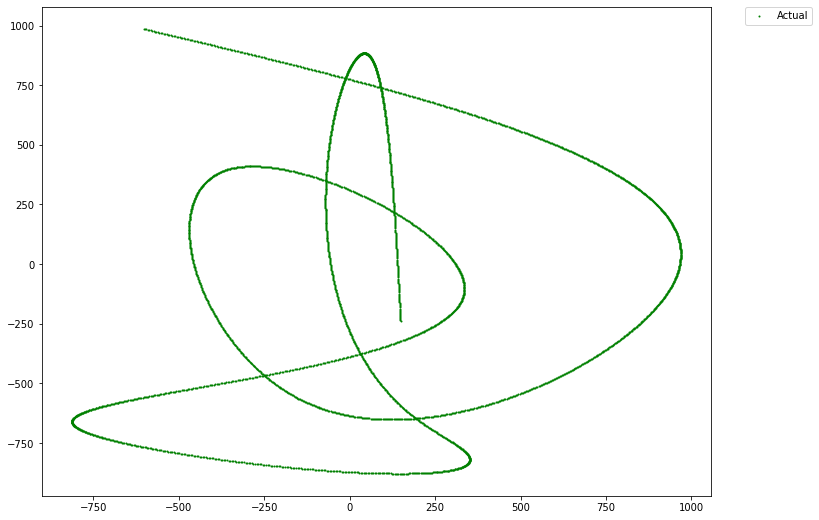

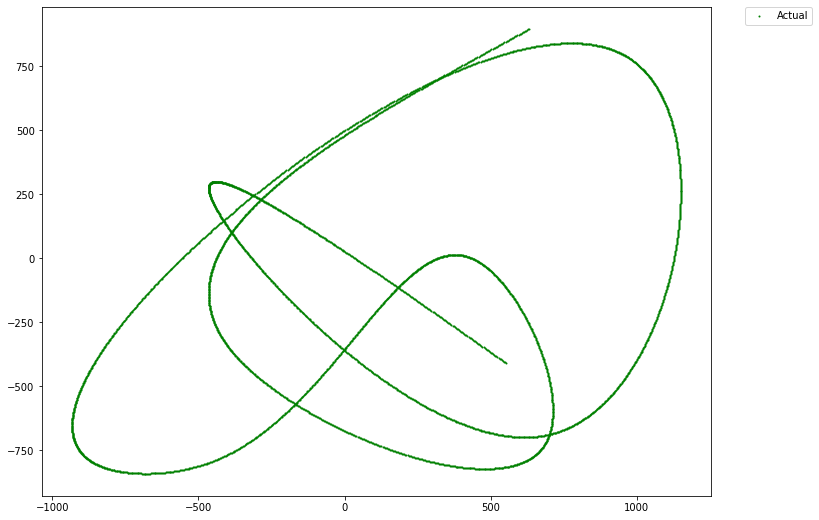

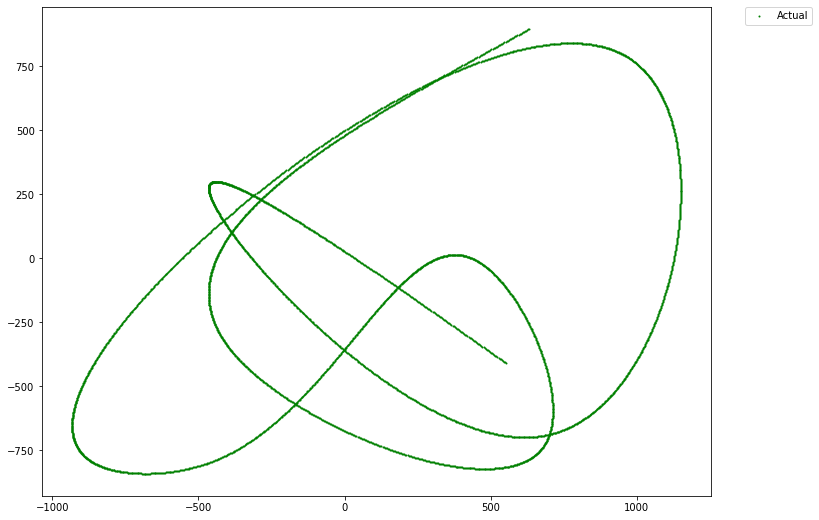

In [222]:
fig = plt.figure(figsize=(12,9))
plt.scatter(T1['X'],T1['Y'],marker='o',c='g',s=1,alpha=1, label="Actual")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

fig = plt.figure(figsize=(12,9))
plt.scatter(T2['X'],T2['Y'],marker='o',c='g',s=1,alpha=1, label="Actual")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

fig = plt.figure(figsize=(12,9))
plt.scatter(T2['X'],T2['Y'],marker='o',c='g',s=1,alpha=1, label="Actual")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


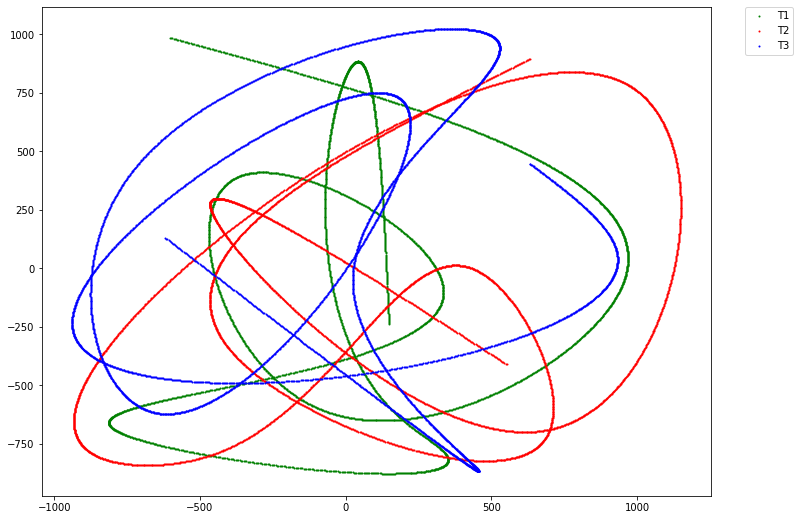

In [254]:
fig = plt.figure(figsize=(12,9))
plt.scatter(T1['X'],T1['Y'],marker='o',c='g',s=1,alpha=1, label="T1")
plt.scatter(T2['X'],T2['Y'],marker='o',c='r',s=1,alpha=1, label="T2")
plt.scatter(T3['X'],T3['Y'],marker='o',c='b',s=1,alpha=1, label="T3")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

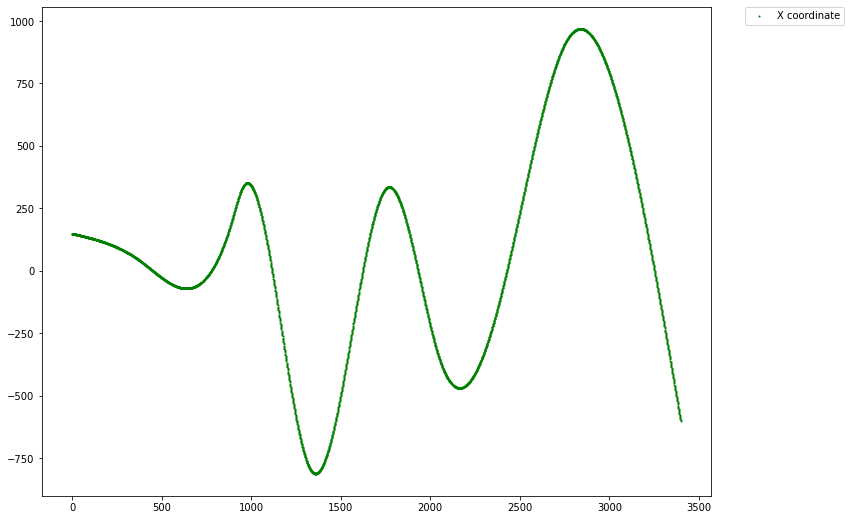

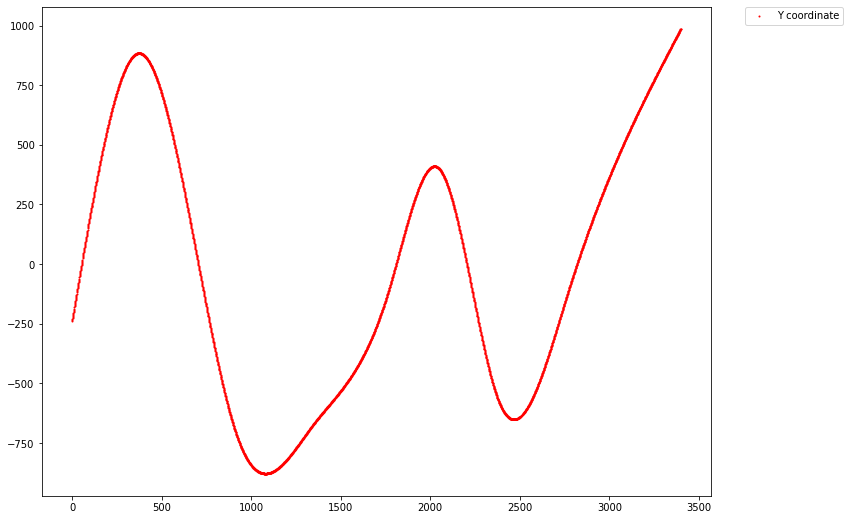

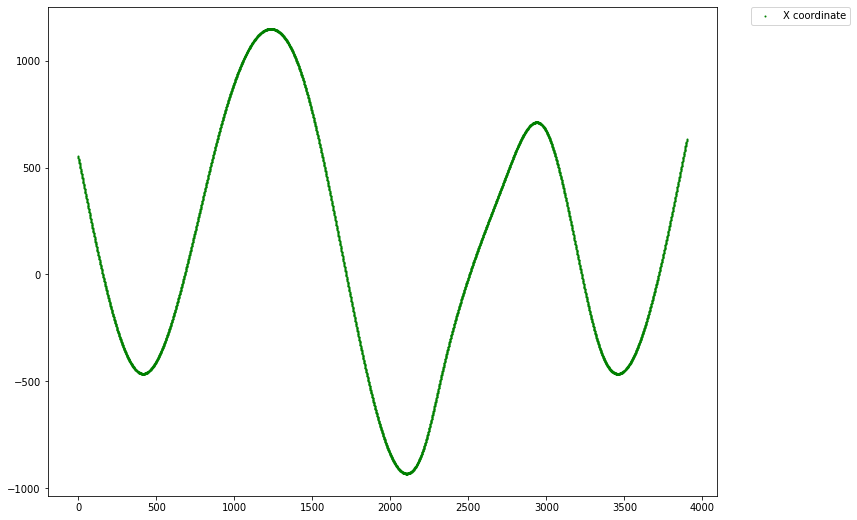

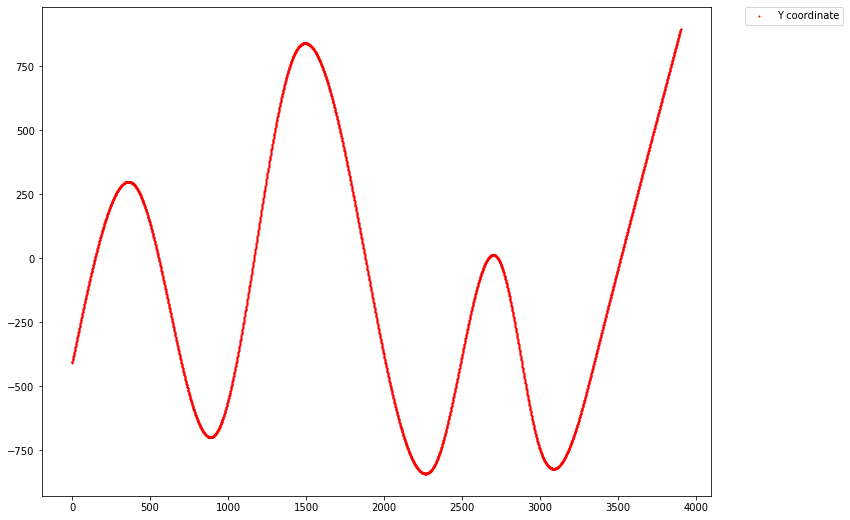

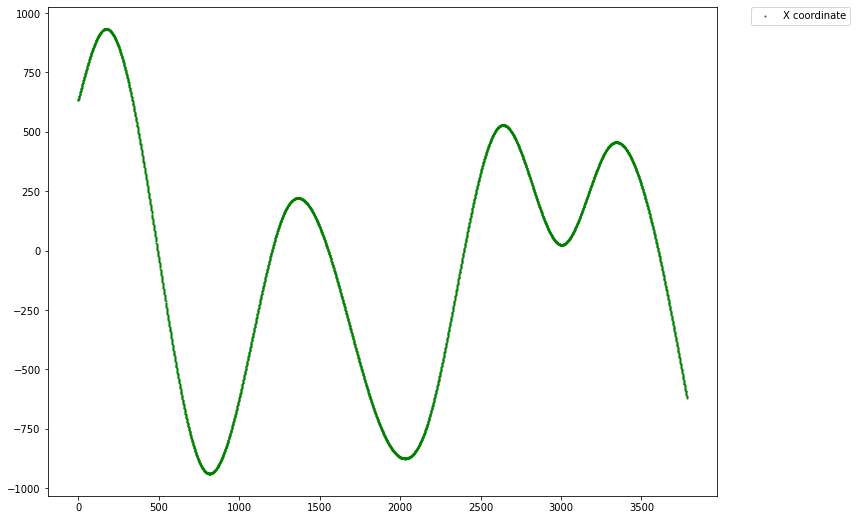

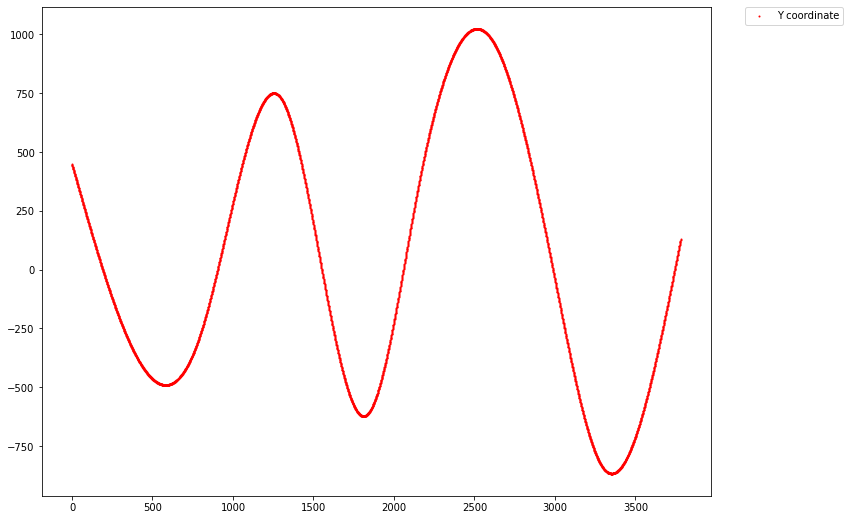

In [224]:
fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(T1['X'])),T1['X'],marker='o',c='g',s=1,alpha=1, label="X coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(T1['Y'])),T1['Y'],marker='o',c='r',s=1,alpha=1, label="Y coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(T2['X'])),T2['X'],marker='o',c='g',s=1,alpha=1, label="X coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(T2['Y'])),T2['Y'],marker='o',c='r',s=1,alpha=1, label="Y coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(T3['X'])),T3['X'],marker='o',c='g',s=1,alpha=1, label="X coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(T3['Y'])),T3['Y'],marker='o',c='r',s=1,alpha=1, label="Y coordinate")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()




# Complile 3 Trajectories into 1 then scale and transform it into supervised problem

In [490]:
new_df = T1
new_df_2 = T2
new_df_3 = T3


In [495]:
#Multi-input
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = new_df[['X','Y']]
#dataset = pd.DataFrame(new_df)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print("   Feature Varables       Target Varables")
print(reframed.head())


# load dataset
dataset = new_df_2[['X','Y']]
#dataset = pd.DataFrame(new_df)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler2 = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler2.fit_transform(values)
# frame as supervised learning
reframed_2 = series_to_supervised(scaled, 1, 1)

print(reframed_2.head())

# load dataset
dataset = new_df_3[['X','Y']]
#dataset = pd.DataFrame(new_df)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler3 = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler3.fit_transform(values)
# frame as supervised learning
reframed_3 = series_to_supervised(scaled, 1, 1)
print(reframed_3.head())

   Feature Varables       Target Varables
   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.079378  -0.315985  0.079189 -0.311143
2   0.079189  -0.311143  0.079000 -0.306302
3   0.079000  -0.306302  0.078812 -0.301460
4   0.078812  -0.301460  0.078623 -0.296619
5   0.078623  -0.296619  0.078435 -0.291778
   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.426156  -0.503541  0.422621 -0.500140
2   0.422621  -0.500140  0.419085 -0.496740
3   0.419085  -0.496740  0.415550 -0.493339
4   0.415550  -0.493339  0.412015 -0.489939
5   0.412015  -0.489939  0.408480 -0.486539
   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.677580   0.390514  0.680372  0.387934
2   0.680372   0.387934  0.683164  0.385354
3   0.683164   0.385354  0.685956  0.382775
4   0.685956   0.382775  0.688746  0.380196
5   0.688746   0.380196  0.691536  0.377616


In [496]:
reframed_3

var1(t-1)  var2(t-1)   var1(t)   var2(t)
1      0.677580   0.390514  0.680372  0.387934
2      0.680372   0.387934  0.683164  0.385354
3      0.683164   0.385354  0.685956  0.382775
4      0.685956   0.382775  0.688746  0.380196
5      0.688746   0.380196  0.691536  0.377616
...         ...        ...       ...       ...
3778  -0.638409   0.036072 -0.642337  0.039762
3779  -0.642337   0.039762 -0.646265  0.043451
3780  -0.646265   0.043451 -0.650194  0.047141
3781  -0.650194   0.047141 -0.654123  0.050831
3782  -0.654123   0.050831 -0.658051  0.054521

[3782 rows x 4 columns]

In [497]:
reframed.shape, reframed_2.shape, reframed_3.shape

((3398, 4), (3900, 4), (3782, 4))

In [498]:
frames = [reframed, reframed_2, reframed_3]
result = pd.concat(frames)
reframed = pd.DataFrame(result)

reframed = reframed.reset_index()
reframed = reframed.drop(['index'], axis=1)
reframed.tail()

var1(t-1)  var2(t-1)   var1(t)   var2(t)
11075  -0.638409   0.036072 -0.642337  0.039762
11076  -0.642337   0.039762 -0.646265  0.043451
11077  -0.646265   0.043451 -0.650194  0.047141
11078  -0.650194   0.047141 -0.654123  0.050831
11079  -0.654123   0.050831 -0.658051  0.054521

# Deep learning Models framework for forecasting one step forward of user element.

# Split data into train and test datasets before feeding the model.

In [450]:
# split into train and test sets
values = reframed.values
n_train = round(reframed.shape[0]*0.2)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, 2:]
test_X, test_y = test[:, :-2], test[:, 2:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2216, 1, 2) (2216, 2) (8864, 1, 2) (8864, 2)


# Train LSTM model

In [451]:
# design single LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model1 = Sequential()
model1.add(LSTM(64,activation='relu' ,input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.1))
model1.add(Dense(test_y.shape[1]))
model1.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model1.summary()
# fit network
history1 = model1.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 64)                17152     
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 130       
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
31/31 - 4s - loss: 0.4077 - accuracy: 0.6042 - val_loss: 0.4730 - val_accuracy: 0.7810
Epoch 2/600
31/31 - 0s - loss: 0.3855 - accuracy: 0.8565 - val_loss: 0.4546 - val_accuracy: 0.8625
Epoch 3/600
31/31 - 0s - loss: 0.3649 - accuracy: 0.8655 - val_loss: 0.4326 - val_accuracy: 0.9106
Epoch 4/600
31/31 - 0s - loss: 0.3409 - accuracy: 0.8953 - val_loss: 0.4054 - val_

277/277 [==============================] - 1s 2ms/step - loss: 0.0467 - accuracy: 0.9876
Accuracy: 98.7590
Test RMSE: 0.078279


# Display accuracy of LSTM model

In [453]:
yhat = model1.predict(test_X)
_, accuracy = model1.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

277/277 [==============================] - 0s 2ms/step - loss: 0.0467 - accuracy: 0.9876
Accuracy: 98.7590
Test RMSE: 0.078279


# Print error distance by RMSE metric and Plot the actual data vs predicted data

In [452]:
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Test RMSE: 75.516244
Train RMSE: 82.220561
RMSE for X in Train dataset: 92.261697
RMSE for Y in Train dataset: 70.768783
RMSE for X in Test dataset: 89.870132
RMSE for Y in Test dataset: 57.695346


# Train stacked LSTMs

In [469]:
# design stacked LSTM network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)

model2 = Sequential()

# first layer
model2.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))

# Second layer
model2.add(LSTM(units=128,return_sequences=False))
model2.add(Dropout(0.1))

# Thrid dense layer
model2.add(Dense(units=(test_y.shape[1])))

model2.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model2.summary()

history2 = model2.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

model2.summary()


# plot history
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 1, 64)             17152     
_________________________________________________________________
lstm_43 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 258       
Total params: 116,226
Trainable params: 116,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
31/31 - 11s - loss: 0.3991 - accuracy: 0.6742 - val_loss: 0.4518 - val_accuracy: 0.8579
Epoch 2/600
31/31 - 0s - loss: 0.3442 - accuracy: 0.8764 - val_loss: 0.3613 - val_accuracy: 0.8523
Epoch 3/600
31/31 - 0s - loss: 0.2182 - accura

# Display accuracy of stacked LSTMs model

In [470]:
yhat = model2.predict(test_X)
_, accuracy = model2.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

277/277 [==============================] - 2s 2ms/step - loss: 0.0463 - accuracy: 0.9720
Accuracy: 97.2022
Test RMSE: 0.063249


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 58.805422
Train RMSE: 63.534551
RMSE for X in Train dataset: 11.147062
RMSE for Y in Train dataset: 89.157326
RMSE for X in Test dataset: 19.842294
RMSE for Y in Test dataset: 80.761645


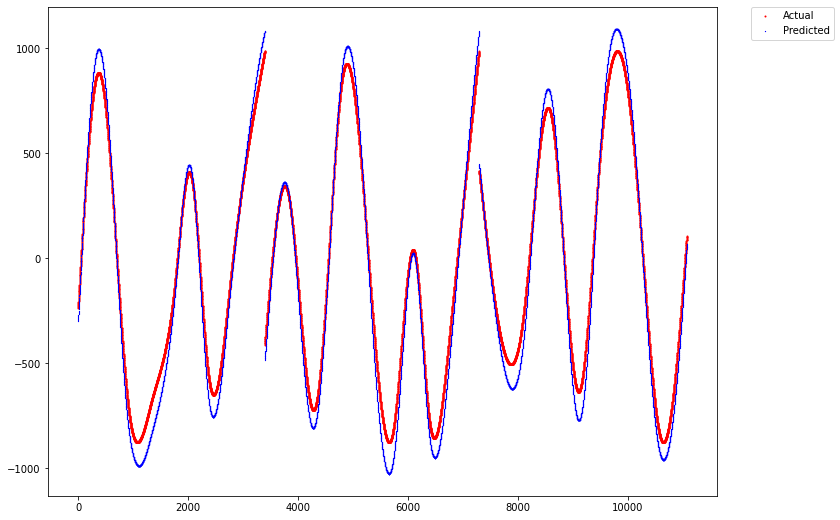

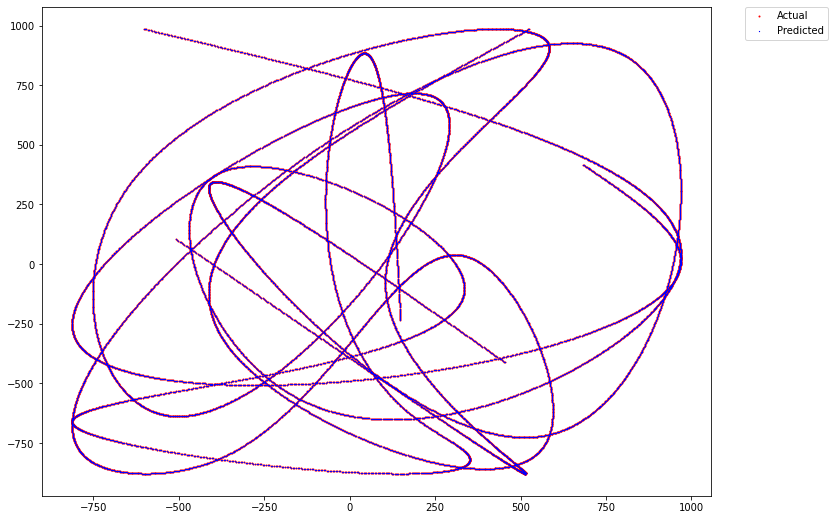

In [471]:
# make a prediction
yhat = model2.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model2.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train Bidirectional LSTM model

Epoch 1/600
31/31 - 8s - loss: 0.3637 - accuracy: 0.8272 - val_loss: 0.3782 - val_accuracy: 0.9436
Epoch 2/600
31/31 - 0s - loss: 0.2706 - accuracy: 0.9066 - val_loss: 0.2668 - val_accuracy: 0.9427
Epoch 3/600
31/31 - 0s - loss: 0.1628 - accuracy: 0.8827 - val_loss: 0.1358 - val_accuracy: 0.9292
Epoch 4/600
31/31 - 0s - loss: 0.0694 - accuracy: 0.9233 - val_loss: 0.0765 - val_accuracy: 0.9663
Epoch 5/600
31/31 - 0s - loss: 0.0345 - accuracy: 0.9639 - val_loss: 0.0528 - val_accuracy: 0.9775
Epoch 6/600
31/31 - 0s - loss: 0.0437 - accuracy: 0.9725 - val_loss: 0.0563 - val_accuracy: 0.9654
Epoch 7/600
31/31 - 0s - loss: 0.0345 - accuracy: 0.9720 - val_loss: 0.0541 - val_accuracy: 0.9814
Epoch 8/600
31/31 - 0s - loss: 0.0454 - accuracy: 0.9689 - val_loss: 0.0506 - val_accuracy: 0.9621
Epoch 9/600
31/31 - 0s - loss: 0.0335 - accuracy: 0.9747 - val_loss: 0.0485 - val_accuracy: 0.9751
Epoch 10/600
31/31 - 0s - loss: 0.0365 - accuracy: 0.9725 - val_loss: 0.0441 - val_accuracy: 0.9672
Epoch 11/

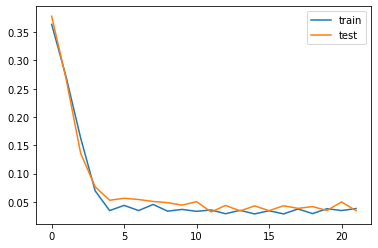

In [457]:
from keras.layers import Bidirectional

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model3 = Sequential()
model3.add(Bidirectional(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2]))))
model3.add(Dropout(0.1))
model3.add(Dense(2))
model3.compile(loss='mae', optimizer='adam',metrics=['accuracy'])


# fit network
history3 = model3.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model3.summary()
# plot history
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Display accuracy of bidirectional LSTM model

In [458]:
yhat = model3.predict(test_X)
_, accuracy = model3.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

277/277 [==============================] - 2s 2ms/step - loss: 0.0321 - accuracy: 0.9769
Accuracy: 97.6873
Test RMSE: 0.045717


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 42.532989
Train RMSE: 46.058829
RMSE for X in Train dataset: 8.136556
RMSE for Y in Train dataset: 64.626813
RMSE for X in Test dataset: 12.469401
RMSE for Y in Test dataset: 58.844053


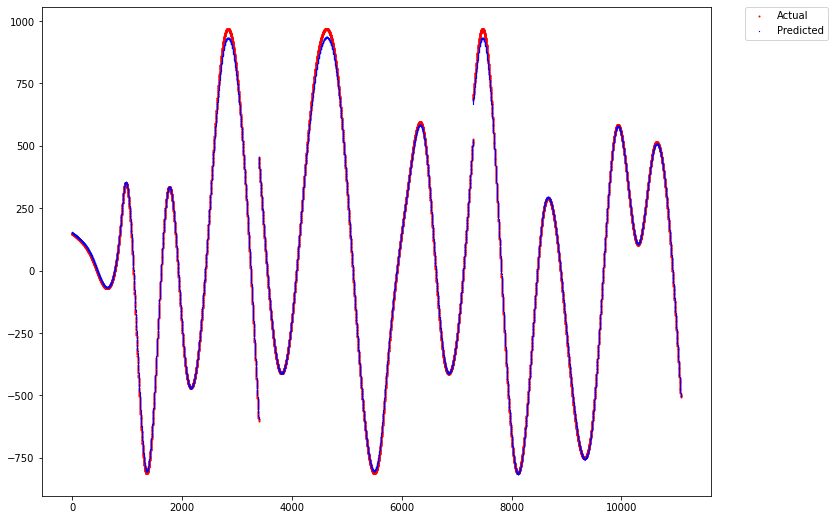

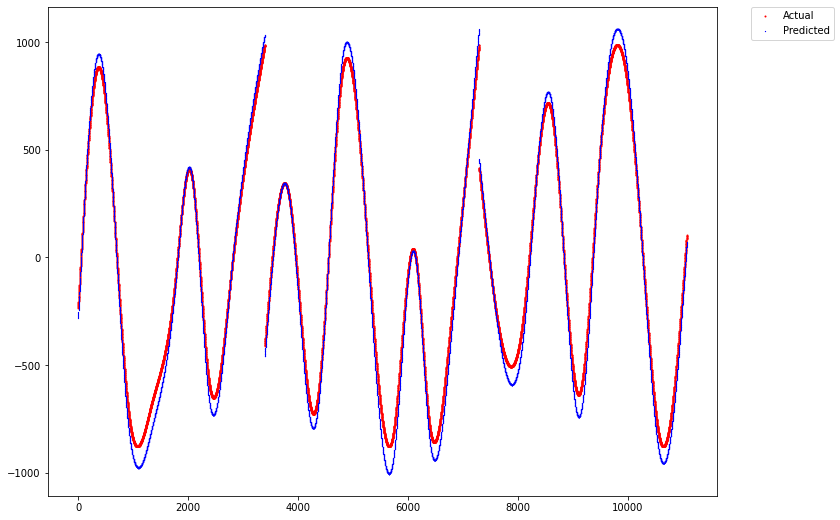

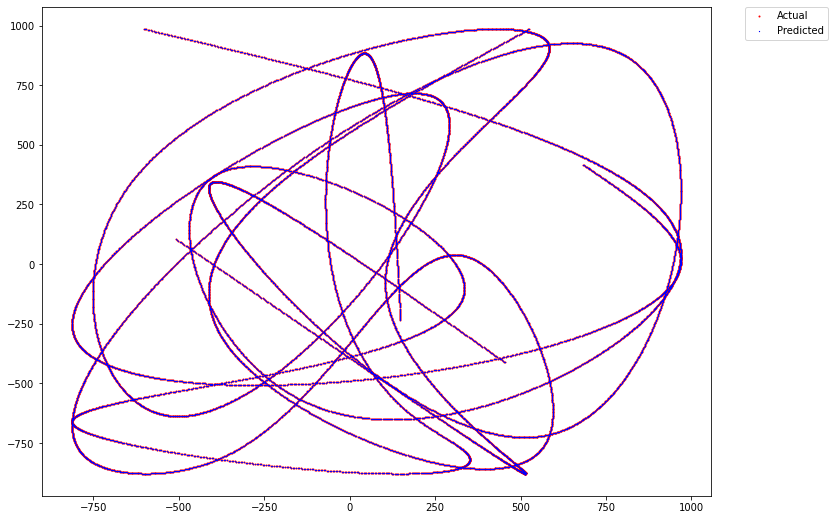

In [459]:
# make a prediction
yhat = model3.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model3.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train GRU model

In [460]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model4 = Sequential()
model4.add(GRU(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model4.add(Dropout(0.1))
model4.add(Dense(2))
model4.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model4.summary()
# fit network
history4 = model4.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history4.history['loss'], label='train')
pyplot.plot(history4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 64)                13056     
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 130       
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
31/31 - 4s - loss: 0.3915 - accuracy: 0.6142 - val_loss: 0.4237 - val_accuracy: 0.9025
Epoch 2/600
31/31 - 0s - loss: 0.3105 - accuracy: 0.8962 - val_loss: 0.3415 - val_accuracy: 0.9587
Epoch 3/600
31/31 - 0s - loss: 0.2401 - accuracy: 0.9535 - val_loss: 0.2518 - val_accuracy: 0.9862
Epoch 4/600
31/31 - 0s - loss: 0.1598 - accuracy: 0.9662 - val_loss: 0.1538 - val_

# Display accuracy of GRU model

In [461]:
yhat = model4.predict(test_X)
_, accuracy = model4.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

277/277 [==============================] - 1s 2ms/step - loss: 0.0090 - accuracy: 0.9958
Accuracy: 99.5826
Test RMSE: 0.012871


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 11.709877
Train RMSE: 5.715306
RMSE for X in Train dataset: 5.652319
RMSE for Y in Train dataset: 5.777608
RMSE for X in Test dataset: 11.977080
RMSE for Y in Test dataset: 11.436454


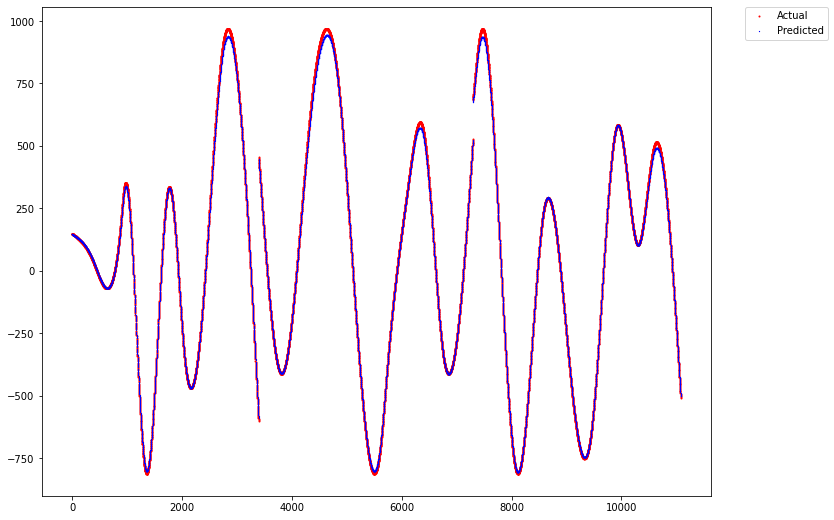

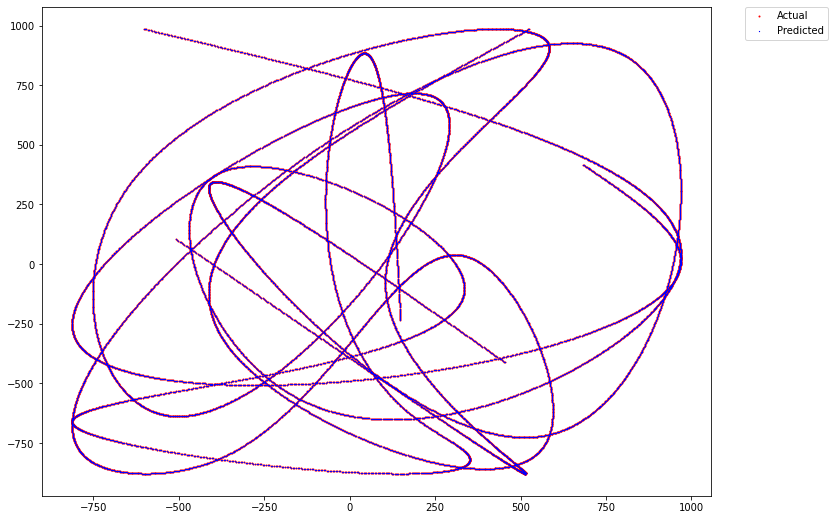

In [462]:
# make a prediction
yhat = model4.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model4.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train stacked GRUs model

In [463]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model5 = Sequential()
model5.add(GRU(32,return_sequences=True, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))

model5.add(GRU(units=64, activation='tanh',return_sequences=False))
model5.add(Dropout(0.1))
model5.add(Dense(2))
model5.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model5.summary()

# fit network
history5 = model5.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history5.history['loss'], label='train')
pyplot.plot(history5.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 1, 32)             3456      
_________________________________________________________________
gru_16 (GRU)                 (None, 64)                18816     
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 130       
Total params: 22,402
Trainable params: 22,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
31/31 - 6s - loss: 0.3868 - accuracy: 0.6331 - val_loss: 0.4090 - val_accuracy: 0.7681
Epoch 2/600
31/31 - 0s - loss: 0.2940 - accuracy: 0.8547 - val_loss: 0.2896 - val_accuracy: 0.8035
Epoch 3/600
31/31 - 0s - loss: 0.1568 - accuracy:

# Display accuracy of stacked LSTMs model

In [464]:
yhat = model5.predict(test_X)
_, accuracy = model5.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

277/277 [==============================] - 2s 2ms/step - loss: 0.0466 - accuracy: 0.9675
Accuracy: 96.7509
Test RMSE: 0.061861


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 55.370970
Train RMSE: 55.484945
RMSE for X in Train dataset: 73.233140
RMSE for Y in Train dataset: 28.179271
RMSE for X in Test dataset: 73.689816
RMSE for Y in Test dataset: 26.489661


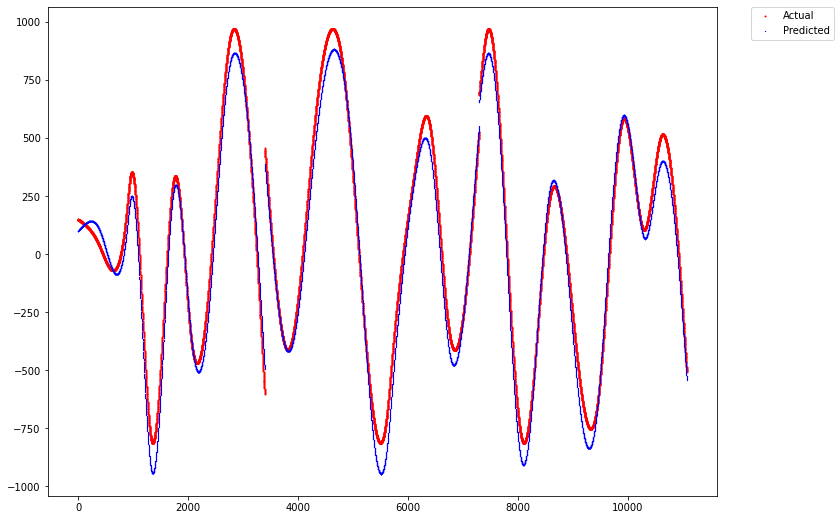

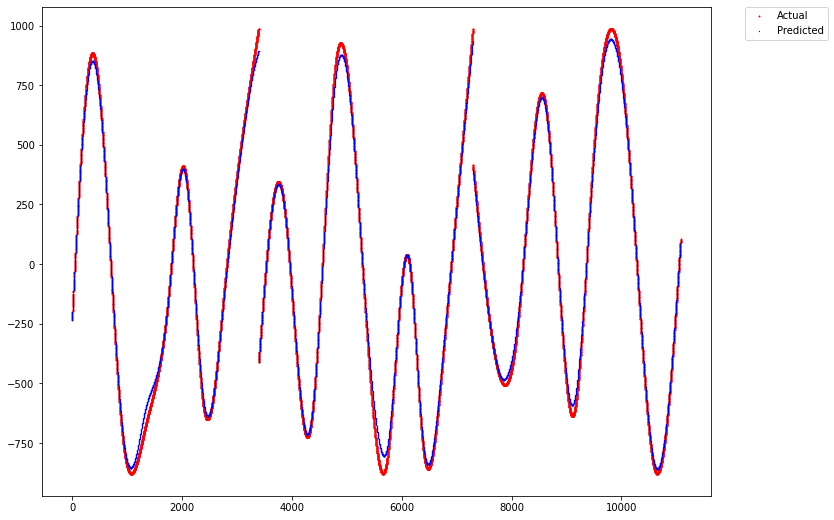

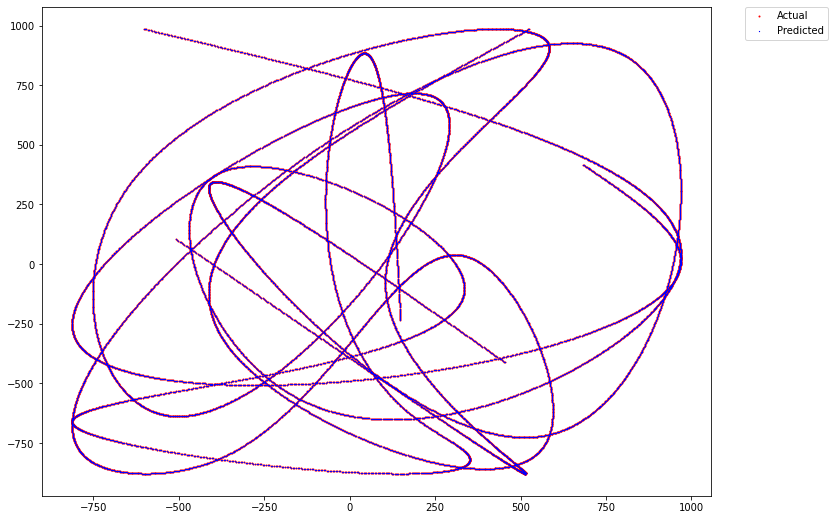

In [465]:
# make a prediction
yhat = model5.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model5.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Train stacked RNN model

In [466]:

# design network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=10,restore_best_weights=True)
model6 = Sequential()
model6.add(SimpleRNN(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model6.add(Dropout(0.1))
model6.add(Dense(2))
model6.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model6.summary()

# fit network
history6 = model6.fit(train_X, train_y, epochs=600, callbacks=[callback], batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history6.history['loss'], label='train')
pyplot.plot(history6.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 64)                4288      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 130       
Total params: 4,418
Trainable params: 4,418
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
31/31 - 3s - loss: 0.2301 - accuracy: 0.9319 - val_loss: 0.1765 - val_accuracy: 0.9689
Epoch 2/600
31/31 - 0s - loss: 0.0848 - accuracy: 0.9251 - val_loss: 0.0713 - val_accuracy: 0.9630
Epoch 3/600
31/31 - 0s - loss: 0.0538 - accuracy: 0.9540 - val_loss: 0.0257 - val_accuracy: 0.9807
Epoch 4/600
31/31 - 0s - loss: 0.0471 - accuracy: 0.9720 - val_loss: 0.0202 - val_ac

# Display accuracy of RNN model

In [467]:
yhat = model6.predict(test_X)
_, accuracy = model6.evaluate(test_X, test_y)
print('Accuracy: %.4f' % (accuracy*100))

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.6f' % rmse)

277/277 [==============================] - 1s 2ms/step - loss: 0.0065 - accuracy: 0.9970
Accuracy: 99.6954
Test RMSE: 0.008369


# Print error distance by RMSE metric and Plot the actual data vs predicted data

Test RMSE: 7.517022
Train RMSE: 8.194530
RMSE for X in Train dataset: 10.581666
RMSE for Y in Train dataset: 4.725352
RMSE for X in Test dataset: 9.547344
RMSE for Y in Test dataset: 4.675427


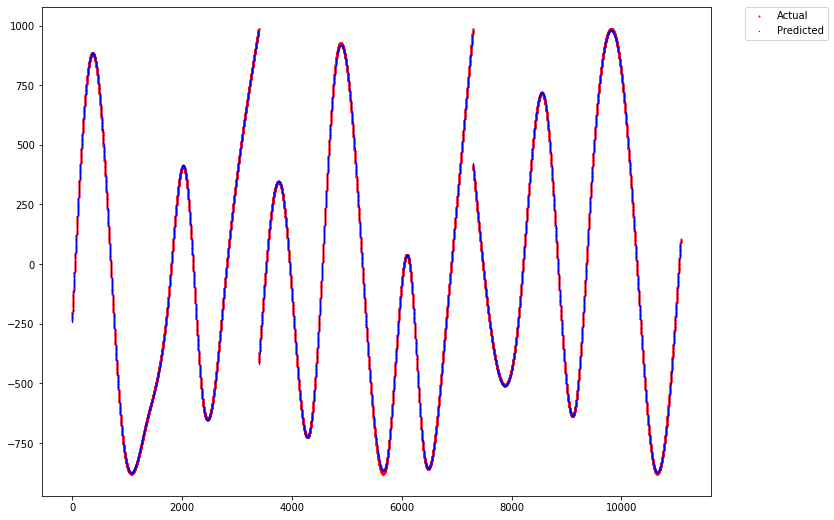

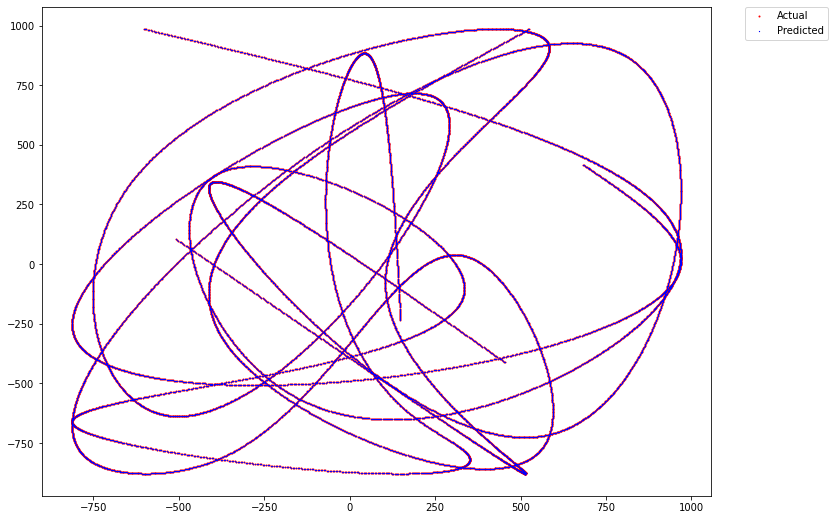

In [468]:
# make a prediction
yhat = model6.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# make a prediction
yhat2 = model6.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

# invert scaling for forecast
inv_yhat2 = scaler.inverse_transform(yhat2)
# invert scaling for actual
inv_y2 = scaler.inverse_transform(train_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.6f' % rmse)


inv_f = np.concatenate((inv_yhat2, inv_yhat), axis=0)
inv_f

inv_o = np.concatenate((inv_y2, inv_y), axis=0)
inv_f,inv_o

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,0], inv_yhat2[:,0]))
print('RMSE for X in Train dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2[:,1], inv_yhat2[:,1]))
print('RMSE for Y in Train dataset: %.6f' % rmse)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('RMSE for X in Test dataset: %.6f' % rmse)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1]))
print('RMSE for Y in Test dataset: %.6f' % rmse)

fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[0],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[0],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(range(0,len(inv_o)),pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(range(0,len(inv_f)),pd.DataFrame(inv_f)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


fig = plt.figure(figsize=(12,9))
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='o',c='r',s=1,alpha=1, label="Actual")
plt.scatter(pd.DataFrame(inv_o)[0],pd.DataFrame(inv_o)[1],marker='^',c='b',s=0.1,alpha=1, label="Predicted")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()